## This notebook aims to visualize the different asset distributions produced by CGAN

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import sys
from tqdm import tqdm

parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../../"))
sys.path.insert(0, parent_dir)

from utilities.gan_plotting import extensive_plotting
from utilities.backtesting_plots import backtest_var_single_asset
from utilities.gan_plotting import load_generated_returns
from backtesting.perform_var_tests import perform_var_backtesting_tests
from backtesting.perform_distribution_tests import perform_distribution_tests
from utilities.gan_plotting import create_rolling_empirical
from sklearn.preprocessing import StandardScaler

from dotenv.main import load_dotenv
load_dotenv(override=True)
import os


In [2]:
import os
print(os.getcwd())

c:\Users\nicka\master-thesis\internal_models\GANs\tuned_GANS


### Parameters

In [3]:
assets_0 = int(os.getenv("INIT_ASSETS"))
liabilities_0 = int(os.getenv("INIT_ASSETS")) * float(os.getenv("FRAC_LIABILITIES"))
num_simulations = int(os.getenv("N_SIMULATIONS"))
bof_0 = assets_0 - liabilities_0

## Note to self -- We only test assets MSCIWORLD, HY and EONIA

In [4]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [3, 6]#[0,1,2,4]
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:400]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [5]:
asset_names = returns_df.columns

num_assets = returns_df.shape[1]
weights = np.full(num_assets, 1 / num_assets)  

## TRAINING CGAN

In [6]:
def plot_generated_scenarios(scenarios, title="Generated Scenarios", num_samples=10):
    """
    Plot a sample of generated scenarios.
    
    Parameters:
      scenarios (np.array): Array of shape (num_scenarios, window_size) with generated return sequences.
      title (str): Title for the plot.
      num_samples (int): Number of scenarios to randomly sample and plot.
    """
    # Sample a few scenarios to avoid overcrowding the plot.
    sample_indices = np.random.choice(scenarios.shape[0], size=min(num_samples, scenarios.shape[0]), replace=False)
    sampled_scenarios = scenarios[sample_indices, :]
    
    plt.figure(figsize=(12, 6))
    for scenario in sampled_scenarios:
        plt.plot(scenario, alpha=0.7)
    plt.title(title)
    plt.xlabel("Days")
    plt.ylabel("Returns")
    plt.grid(True)
    plt.show()

def plot_generated_distribution(scenarios, title="Distribution of Cumulative Returns", bins=500):
    """
    Plot the distribution of cumulative returns computed from the generated scenarios.
    
    Parameters:
      scenarios (np.array): Array of shape (num_scenarios, window_size) with generated return sequences.
      title (str): Title for the plot.
      bins (int): Number of bins for the histogram.
    """
    # Compute cumulative returns for each scenario.
    cumulative_returns = np.array([np.prod(1 + scenario) - 1 for scenario in scenarios])
    
    plt.figure(figsize=(10, 6))
    plt.hist(cumulative_returns, bins=bins, density=True, alpha=0.6, color='b')
    plt.title(title)
    plt.xlabel("Cumulative Return")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()


In [7]:
from OliviaGAN import OliviaGAN
from MarketGAN import MarketGAN
from FashionGAN import FashionGAN

gan_dict = {}

# Dictionary to store generated scenarios by asset and date.
# Structure: { asset_name: { date: generated_scenarios, ... }, ... }
scenarios_results = {}

for asset_name in tqdm(returns_df.columns, desc="Training GANs", unit="asset"):
    print(f"Training GAN for {asset_name}...")
    asset_returns = returns_df[asset_name]
    
    gan = FashionGAN(asset_returns, asset_name)
    gan.train()
    print(f"Finished training GAN for {asset_name}.\n")
    
    scenarios = gan.generate_scenarios(num_scenarios=10000)
    print(f"Finished generating scenarios for {asset_name}.\n")
    
    gan_dict[asset_name] = gan

    initial_date = returns_df.index[-1]
    scenarios_results.setdefault(asset_name, {})[initial_date] = scenarios
    print(f"{asset_name}: Stored initial generated scenarios for {initial_date}.")

Training GANs:   0%|          | 0/2 [00:00<?, ?asset/s]

Training GAN for IG...
[Epoch 0/600] [Batch 0/27] [D loss: 1.4252] [G loss: 81.4677] [Tail penalty: 0.9462] [Structure penalty: 0.9806]
[Epoch 0/600] [Batch 10/27] [D loss: 0.6062] [G loss: 56.9033] [Tail penalty: 0.6500] [Structure penalty: 0.7066]
[Epoch 0/600] [Batch 20/27] [D loss: 0.5040] [G loss: 36.5571] [Tail penalty: 0.4451] [Structure penalty: 0.4016]
[Epoch 1/600] [Batch 0/27] [D loss: 0.7231] [G loss: 22.0172] [Tail penalty: 0.2577] [Structure penalty: 0.2608]
[Epoch 1/600] [Batch 10/27] [D loss: 0.7595] [G loss: 11.7149] [Tail penalty: 0.1236] [Structure penalty: 0.1611]
[Epoch 1/600] [Batch 20/27] [D loss: 0.6367] [G loss: 7.7189] [Tail penalty: 0.0515] [Structure penalty: 0.1638]
[Epoch 2/600] [Batch 0/27] [D loss: 0.6809] [G loss: 7.1410] [Tail penalty: 0.0277] [Structure penalty: 0.1859]
[Epoch 2/600] [Batch 10/27] [D loss: 0.4845] [G loss: 7.3201] [Tail penalty: 0.0067] [Structure penalty: 0.2305]
[Epoch 2/600] [Batch 20/27] [D loss: 0.3789] [G loss: 8.0026] [Tail pen

Training GANs:  50%|█████     | 1/2 [15:46<15:46, 946.77s/asset]

Finished training GAN for IG.

Generated scenarios saved to: generated_CGAN_output_test\generated_returns_IG_final_scenarios.pt
Finished generating scenarios for IG.

IG: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for EONIA...
[Epoch 0/600] [Batch 0/27] [D loss: 24.4493] [G loss: 1098.4091] [Tail penalty: 1.7952] [Structure penalty: 33.3189]
[Epoch 0/600] [Batch 10/27] [D loss: 8.7358] [G loss: 743.1144] [Tail penalty: 1.4392] [Structure penalty: 22.1284]
[Epoch 0/600] [Batch 20/27] [D loss: 6.7615] [G loss: 371.1414] [Tail penalty: 1.1563] [Structure penalty: 10.2477]
[Epoch 1/600] [Batch 0/27] [D loss: 3.0760] [G loss: 163.8833] [Tail penalty: 0.9352] [Structure penalty: 3.7466]
[Epoch 1/600] [Batch 10/27] [D loss: 2.7843] [G loss: 68.0868] [Tail penalty: 0.7486] [Structure penalty: 0.8968]
[Epoch 1/600] [Batch 20/27] [D loss: 2.6609] [G loss: 50.0162] [Tail penalty: 0.6369] [Structure penalty: 0.4972]
[Epoch 2/600] [Batch 0/27] [D loss: 1.7002] [G loss:

Training GANs: 100%|██████████| 2/2 [31:45<00:00, 952.88s/asset]

Finished training GAN for EONIA.

Generated scenarios saved to: generated_CGAN_output_test\generated_returns_EONIA_final_scenarios.pt
Finished generating scenarios for EONIA.

EONIA: Stored initial generated scenarios for 2019-12-31 00:00:00.


In [44]:
for asset_name in tqdm(test_returns_df.columns, desc="Updating GANs", unit="asset"):
    asset_returns = returns_df[asset_name]
    gan = gan_dict[asset_name]
    foundNAN = False
    for test_day in test_returns_df.index:
        new_return = test_returns_df.loc[test_day, asset_name]
        new_row = pd.DataFrame({asset_name: [new_return]}, index=[test_day])
        asset_returns = pd.concat([asset_returns, new_row])
        
        print("date", test_day)

        # test different lookbacks
        scenarios = gan.generate_new_scenarios_from_return(new_return, test_day, 252, save=False, num_scenarios=10000)

        # plot_generated_distribution(scenarios=scenarios)
        has_inf = np.isinf(scenarios).any()
        has_nan = np.isnan(scenarios).any()

        if has_nan or has_inf:
            print("FOUND NAN")
            foundNAN = True
            break

        print(f"{asset_name}: Generated new distribution on {test_day}.")

        scenarios_results.setdefault(asset_name, {})[test_day] = scenarios
        
        print(f"{asset_name}: Stored generated scenarios for {test_day}.")
    
    if foundNAN: break

Updating GANs:   0%|          | 0/2 [00:00<?, ?asset/s]

date 2020-01-02 00:00:00
IG: Generated new distribution on 2020-01-02 00:00:00.
IG: Stored generated scenarios for 2020-01-02 00:00:00.
date 2020-01-03 00:00:00
IG: Generated new distribution on 2020-01-03 00:00:00.
IG: Stored generated scenarios for 2020-01-03 00:00:00.
date 2020-01-06 00:00:00
IG: Generated new distribution on 2020-01-06 00:00:00.
IG: Stored generated scenarios for 2020-01-06 00:00:00.
date 2020-01-07 00:00:00
IG: Generated new distribution on 2020-01-07 00:00:00.
IG: Stored generated scenarios for 2020-01-07 00:00:00.
date 2020-01-08 00:00:00
IG: Generated new distribution on 2020-01-08 00:00:00.
IG: Stored generated scenarios for 2020-01-08 00:00:00.
date 2020-01-09 00:00:00
IG: Generated new distribution on 2020-01-09 00:00:00.
IG: Stored generated scenarios for 2020-01-09 00:00:00.
date 2020-01-10 00:00:00
IG: Generated new distribution on 2020-01-10 00:00:00.
IG: Stored generated scenarios for 2020-01-10 00:00:00.
date 2020-01-13 00:00:00
IG: Generated new distr

Updating GANs:  50%|█████     | 1/2 [08:54<08:54, 534.21s/asset]

IG: Generated new distribution on 2021-07-27 00:00:00.
IG: Stored generated scenarios for 2021-07-27 00:00:00.
date 2020-01-02 00:00:00
EONIA: Generated new distribution on 2020-01-02 00:00:00.
EONIA: Stored generated scenarios for 2020-01-02 00:00:00.
date 2020-01-03 00:00:00
EONIA: Generated new distribution on 2020-01-03 00:00:00.
EONIA: Stored generated scenarios for 2020-01-03 00:00:00.
date 2020-01-06 00:00:00
EONIA: Generated new distribution on 2020-01-06 00:00:00.
EONIA: Stored generated scenarios for 2020-01-06 00:00:00.
date 2020-01-07 00:00:00
EONIA: Generated new distribution on 2020-01-07 00:00:00.
EONIA: Stored generated scenarios for 2020-01-07 00:00:00.
date 2020-01-08 00:00:00
EONIA: Generated new distribution on 2020-01-08 00:00:00.
EONIA: Stored generated scenarios for 2020-01-08 00:00:00.
date 2020-01-09 00:00:00
EONIA: Generated new distribution on 2020-01-09 00:00:00.
EONIA: Stored generated scenarios for 2020-01-09 00:00:00.
date 2020-01-10 00:00:00
EONIA: Gener

Updating GANs: 100%|██████████| 2/2 [17:42<00:00, 531.44s/asset]

EONIA: Generated new distribution on 2021-07-27 00:00:00.
EONIA: Stored generated scenarios for 2021-07-27 00:00:00.


In [45]:
returns_df.tail()

IG     EONIA
Date                          
2019-12-23 -0.000395 -0.000045
2019-12-24  0.001135 -0.000015
2019-12-27  0.001971 -0.000015
2019-12-30 -0.001701 -0.000045
2019-12-31 -0.000746 -0.000015

In [46]:
from internal_models.multivariate_GAN.simple_gan_portfolio import SimpleGANPortfolio
from internal_models.multivariate_GAN.students_copula_GAN import StudentCopula

## We need to get rolling Delta BOF

In [47]:
entire_df = pd.concat([returns_df, test_returns_df])

entire_df.tail()

IG     EONIA
Date                          
2021-07-21 -0.002522 -0.000016
2021-07-22  0.001797 -0.000016
2021-07-23 -0.000580 -0.000016
2021-07-26  0.000473 -0.000047
2021-07-27  0.001789 -0.000016

In [48]:
test_start_date = test_returns_df.index.min()
test_end_date = test_returns_df.index.max()
print("Test end date:", test_end_date)

# Find the index location of the test_start_date in entire_df
idx = entire_df.index.get_loc(test_end_date)
idx_start = entire_df.index.get_loc(test_start_date)

# Slice 252 rows before that index
historical_df = entire_df.iloc[idx_start - 252:]
historical_df.head()

Test end date: 2021-07-27 00:00:00


IG    EONIA
Date                         
2019-01-03  0.003209 -0.00001
2019-01-04 -0.004488 -0.00001
2019-01-07  0.000024 -0.00003
2019-01-08 -0.000592 -0.00001
2019-01-09  0.001019 -0.00001

In [49]:
historical_df.tail()

IG     EONIA
Date                          
2021-07-21 -0.002522 -0.000016
2021-07-22  0.001797 -0.000016
2021-07-23 -0.000580 -0.000016
2021-07-26  0.000473 -0.000047
2021-07-27  0.001789 -0.000016

In [50]:
entire_df.tail()

IG     EONIA
Date                          
2021-07-21 -0.002522 -0.000016
2021-07-22  0.001797 -0.000016
2021-07-23 -0.000580 -0.000016
2021-07-26  0.000473 -0.000047
2021-07-27  0.001789 -0.000016

# CASE 1

- We first calculate realized delta BOF for a given window

In [51]:
# CALCULATE DELTA BOF ARRAY
eonia = historical_df.iloc[:, -1]
bof_0 = assets_0 - liabilities_0

portfolio_returns = (historical_df * weights).sum(axis=1)

portfolio_value = assets_0 * (1 + portfolio_returns).cumprod()

liabilities = liabilities_0 * (1 + eonia).cumprod()

bof = portfolio_value - liabilities

daily_delta_bof = bof.diff().fillna(0)


rolling_delta_bof = daily_delta_bof.rolling(window=252).sum()


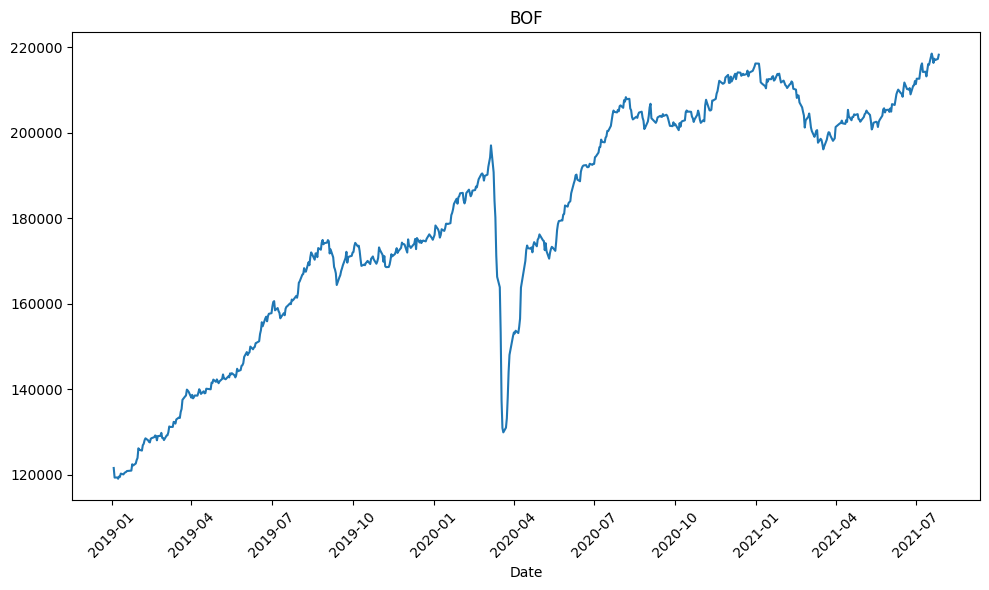

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(bof.index, bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("BOF")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

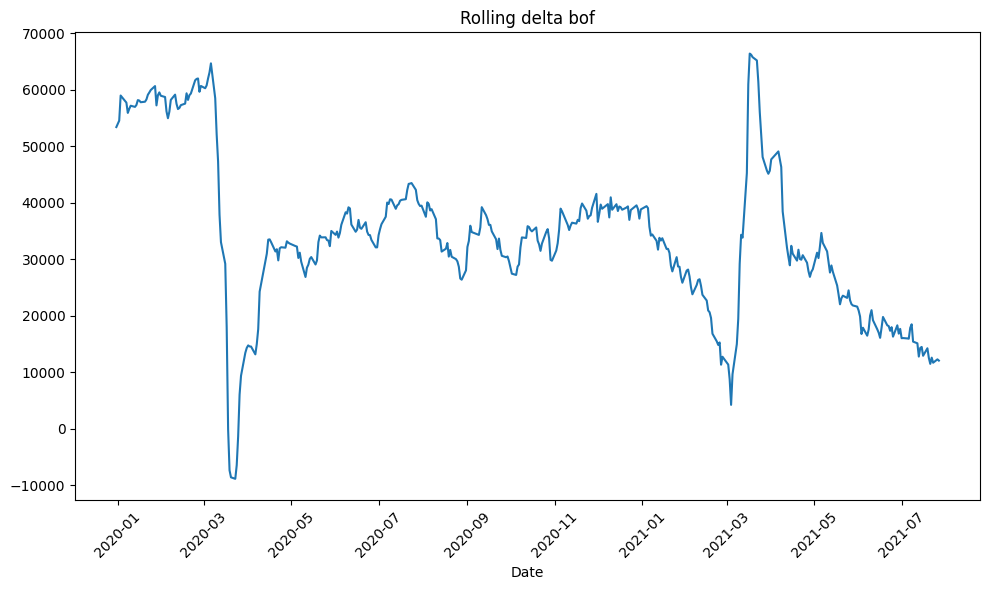

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(rolling_delta_bof.index, rolling_delta_bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("Rolling delta bof")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

# Case 2

Same, assuming constant BOF0

In [54]:
bof.loc["2019-12-31"]

np.float64(174967.82065186684)

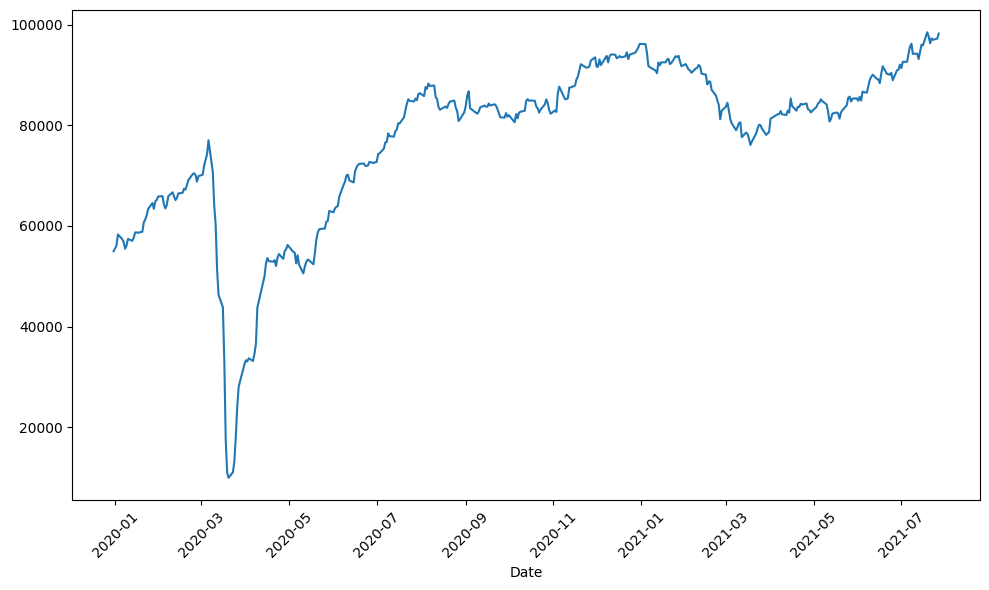

In [55]:
bof_case_ii = bof.loc["2019-12-31":]

delta_bof_case_ii = bof_case_ii - bof_0

plt.figure(figsize=(10, 6))
plt.plot(delta_bof_case_ii.index, delta_bof_case_ii.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

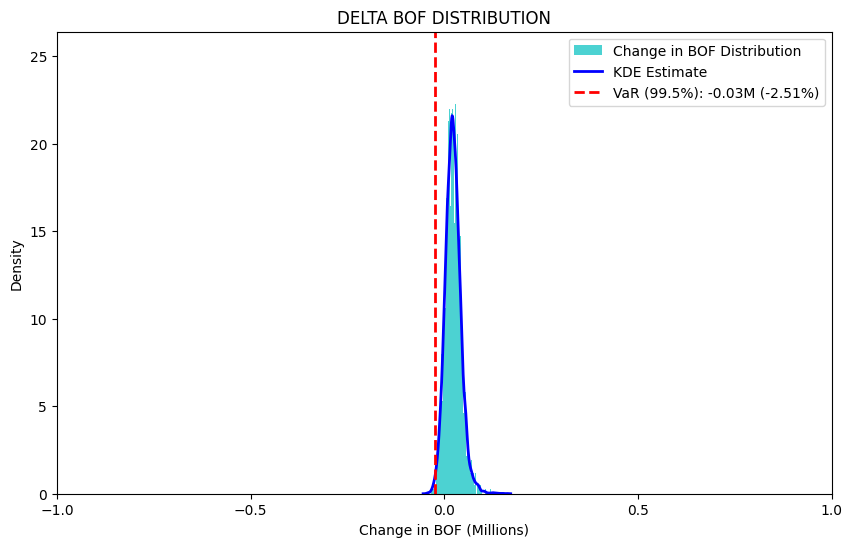

Date 2019-12-31 00:00:00: SCR = -25066.35433241844
Date 2020-01-02 00:00:00: SCR = -15801.624326953885
Date 2020-01-03 00:00:00: SCR = -15542.565172739007
Date 2020-01-06 00:00:00: SCR = -18110.39613128662
Date 2020-01-07 00:00:00: SCR = -18954.623154640194
Date 2020-01-08 00:00:00: SCR = -16566.849200067514
Date 2020-01-09 00:00:00: SCR = -18153.205328073498
Date 2020-01-10 00:00:00: SCR = -17487.97798198699
Date 2020-01-13 00:00:00: SCR = -17179.789152135847
Date 2020-01-14 00:00:00: SCR = -17833.59071957588
Date 2020-01-15 00:00:00: SCR = -16991.09240949631
Date 2020-01-16 00:00:00: SCR = -18986.765080537785
Date 2020-01-17 00:00:00: SCR = -19541.18477252006
Date 2020-01-20 00:00:00: SCR = -17866.364500541684
Date 2020-01-21 00:00:00: SCR = -17958.154433488846
Date 2020-01-22 00:00:00: SCR = -17759.602982397064
Date 2020-01-23 00:00:00: SCR = -17833.018734712598
Date 2020-01-24 00:00:00: SCR = -17622.751088104247
Date 2020-01-27 00:00:00: SCR = -18019.19423570632


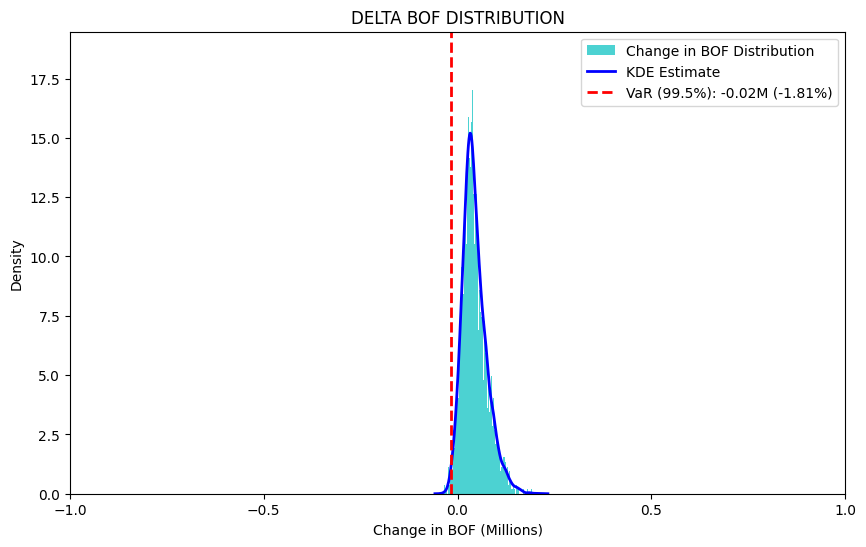

Date 2020-01-28 00:00:00: SCR = -18110.267792701714
Date 2020-01-29 00:00:00: SCR = -19423.914276447293
Date 2020-01-30 00:00:00: SCR = -18243.503674106585
Date 2020-01-31 00:00:00: SCR = -18866.83361030577
Date 2020-02-03 00:00:00: SCR = -17840.567303371423
Date 2020-02-04 00:00:00: SCR = -18654.296087770454
Date 2020-02-05 00:00:00: SCR = -17336.9707583332
Date 2020-02-06 00:00:00: SCR = -20454.601533660883
Date 2020-02-07 00:00:00: SCR = -19635.459077920885
Date 2020-02-10 00:00:00: SCR = -21082.3865838146
Date 2020-02-11 00:00:00: SCR = -19348.297164077754
Date 2020-02-12 00:00:00: SCR = -19757.694275197948
Date 2020-02-13 00:00:00: SCR = -18628.1520898056
Date 2020-02-14 00:00:00: SCR = -19879.302010526655
Date 2020-02-17 00:00:00: SCR = -19595.456350336062
Date 2020-02-18 00:00:00: SCR = -19351.402109289163
Date 2020-02-19 00:00:00: SCR = -19252.00655421257
Date 2020-02-20 00:00:00: SCR = -21179.107119665143
Date 2020-02-21 00:00:00: SCR = -19191.543380584706
Date 2020-02-24 00:0

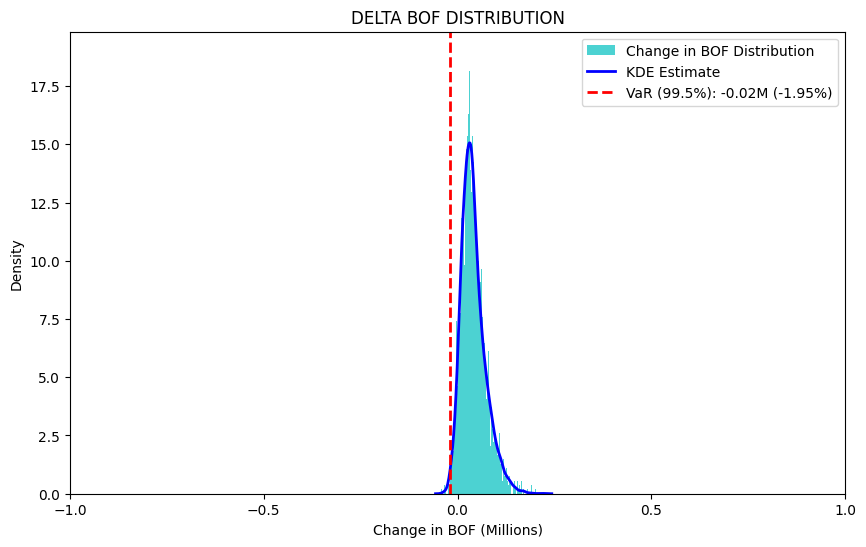

Date 2020-02-25 00:00:00: SCR = -19547.75693357467
Date 2020-02-26 00:00:00: SCR = -20336.181637964237
Date 2020-02-27 00:00:00: SCR = -18352.53208087921
Date 2020-02-28 00:00:00: SCR = -19827.233361549377
Date 2020-03-02 00:00:00: SCR = -20947.821679220182
Date 2020-03-03 00:00:00: SCR = -20969.114863519666
Date 2020-03-04 00:00:00: SCR = -20694.961944293962
Date 2020-03-05 00:00:00: SCR = -18316.79339178085
Date 2020-03-06 00:00:00: SCR = -21994.599354200356
Date 2020-03-09 00:00:00: SCR = -20668.54930315971
Date 2020-03-10 00:00:00: SCR = -21924.013169517515
Date 2020-03-11 00:00:00: SCR = -20436.428934593187
Date 2020-03-12 00:00:00: SCR = -20143.80426412582
Date 2020-03-13 00:00:00: SCR = -20062.858534650793
Date 2020-03-16 00:00:00: SCR = -21751.414694099418
Date 2020-03-17 00:00:00: SCR = -20873.411196699144
Date 2020-03-18 00:00:00: SCR = -20167.40616493224
Date 2020-03-19 00:00:00: SCR = -21024.09961260795
Date 2020-03-20 00:00:00: SCR = -21948.481907691952
Date 2020-03-23 00:

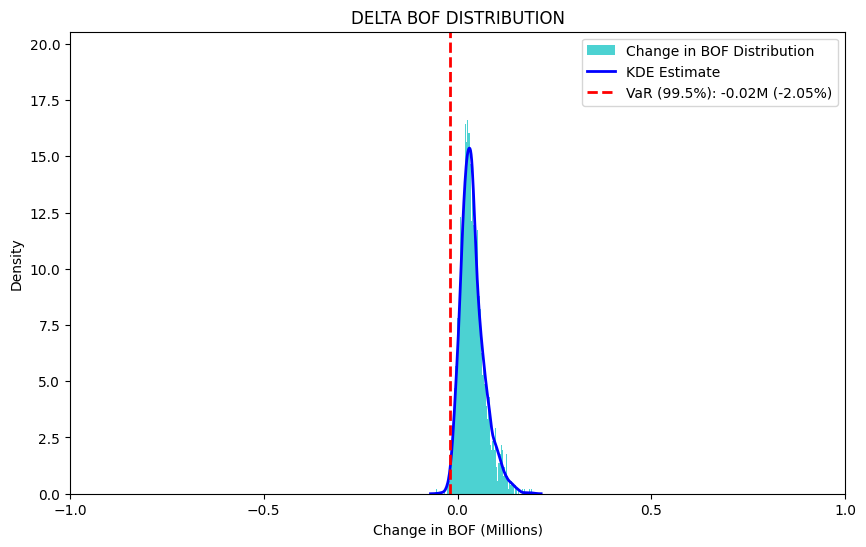

Date 2020-03-24 00:00:00: SCR = -20458.02162545204
Date 2020-03-25 00:00:00: SCR = -21884.219875030507
Date 2020-03-26 00:00:00: SCR = -19294.098025207513
Date 2020-03-27 00:00:00: SCR = -19925.002861566536
Date 2020-03-30 00:00:00: SCR = -20050.527939014428
Date 2020-03-31 00:00:00: SCR = -19384.23650882721
Date 2020-04-01 00:00:00: SCR = -20593.75299131393
Date 2020-04-02 00:00:00: SCR = -18564.945680084227
Date 2020-04-03 00:00:00: SCR = -19273.366782426827
Date 2020-04-06 00:00:00: SCR = -20009.499566078175
Date 2020-04-07 00:00:00: SCR = -20886.854518890377
Date 2020-04-08 00:00:00: SCR = -20127.36033384323
Date 2020-04-09 00:00:00: SCR = -19691.435050888053
Date 2020-04-14 00:00:00: SCR = -20554.483307914732
Date 2020-04-15 00:00:00: SCR = -20680.32260026931
Date 2020-04-16 00:00:00: SCR = -20027.70202713012
Date 2020-04-17 00:00:00: SCR = -21104.3838875389
Date 2020-04-20 00:00:00: SCR = -20256.907470750804
Date 2020-04-21 00:00:00: SCR = -21475.60506334305
Date 2020-04-22 00:00

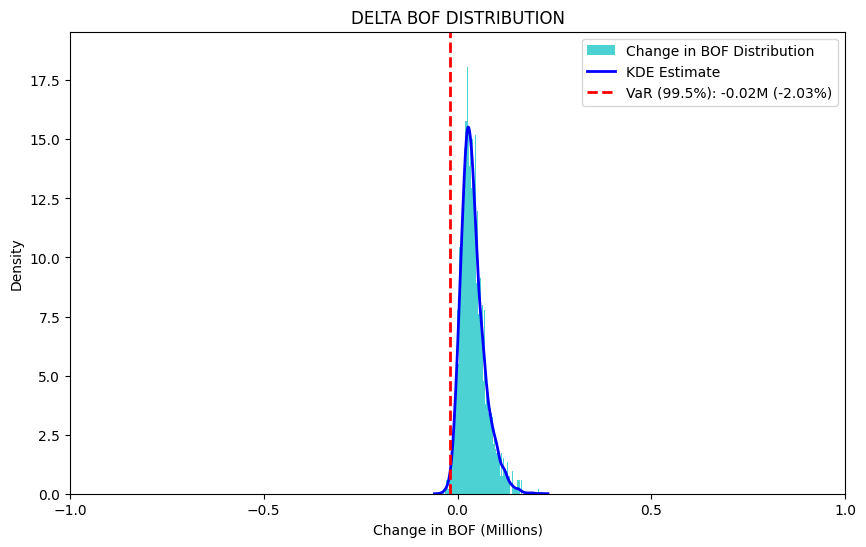

Date 2020-04-23 00:00:00: SCR = -20336.131362295146
Date 2020-04-24 00:00:00: SCR = -20090.73508942603
Date 2020-04-27 00:00:00: SCR = -21245.614559211732
Date 2020-04-28 00:00:00: SCR = -20217.93235084532
Date 2020-04-29 00:00:00: SCR = -19361.57222142219
Date 2020-04-30 00:00:00: SCR = -22460.478619585032
Date 2020-05-04 00:00:00: SCR = -20064.918016576765
Date 2020-05-05 00:00:00: SCR = -19035.17814609527
Date 2020-05-06 00:00:00: SCR = -19903.82040351867
Date 2020-05-07 00:00:00: SCR = -19483.897660999293
Date 2020-05-08 00:00:00: SCR = -21628.49888293265
Date 2020-05-11 00:00:00: SCR = -18941.833261356347
Date 2020-05-12 00:00:00: SCR = -20215.56772750854
Date 2020-05-13 00:00:00: SCR = -20706.811475658407
Date 2020-05-14 00:00:00: SCR = -21146.55487844467
Date 2020-05-15 00:00:00: SCR = -20464.243403844834
Date 2020-05-18 00:00:00: SCR = -20808.91112742424
Date 2020-05-19 00:00:00: SCR = -20835.238042612073
Date 2020-05-20 00:00:00: SCR = -21128.971942892073
Date 2020-05-21 00:00

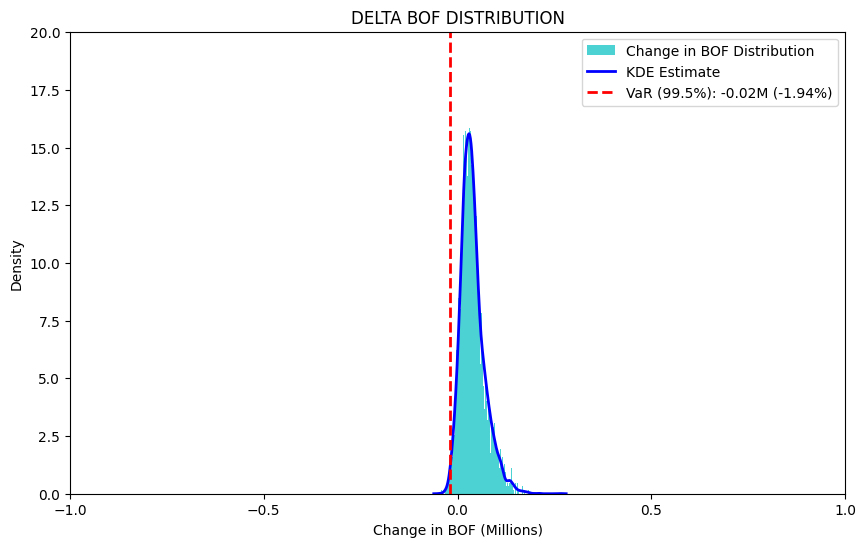

Date 2020-05-22 00:00:00: SCR = -19391.90960471153
Date 2020-05-25 00:00:00: SCR = -20820.93317825317
Date 2020-05-26 00:00:00: SCR = -20330.26052108764
Date 2020-05-27 00:00:00: SCR = -19358.725481681824
Date 2020-05-28 00:00:00: SCR = -19346.58929910659
Date 2020-05-29 00:00:00: SCR = -18698.62911707877
Date 2020-06-01 00:00:00: SCR = -19784.447209548947
Date 2020-06-02 00:00:00: SCR = -21638.473134040825
Date 2020-06-03 00:00:00: SCR = -19851.552604484536
Date 2020-06-04 00:00:00: SCR = -20705.54764542579
Date 2020-06-05 00:00:00: SCR = -21230.369027719495
Date 2020-06-08 00:00:00: SCR = -21546.074099798203
Date 2020-06-09 00:00:00: SCR = -21151.286577243798
Date 2020-06-10 00:00:00: SCR = -19746.241170616147
Date 2020-06-11 00:00:00: SCR = -17726.87067811965
Date 2020-06-12 00:00:00: SCR = -19235.12074059485
Date 2020-06-15 00:00:00: SCR = -19145.085435752862
Date 2020-06-16 00:00:00: SCR = -20239.046982517237
Date 2020-06-17 00:00:00: SCR = -20068.290929155348
Date 2020-06-18 00:0

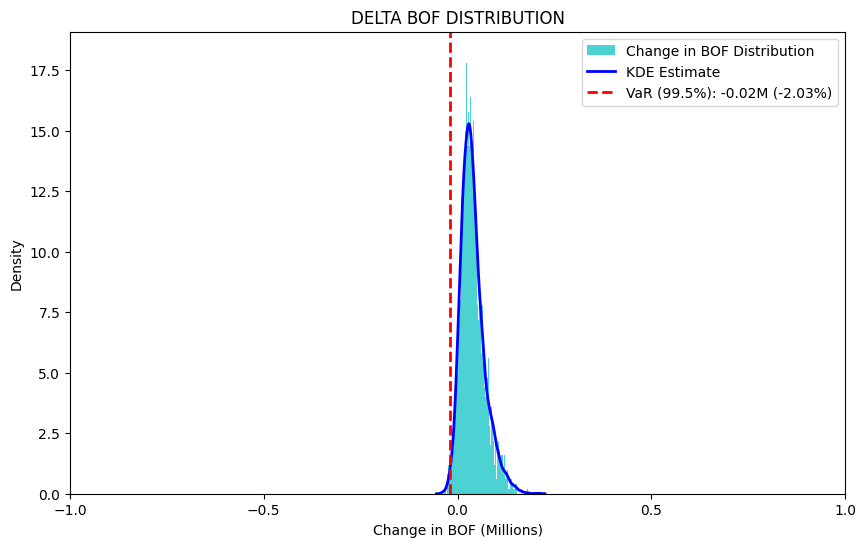

Date 2020-06-19 00:00:00: SCR = -20317.119674491878
Date 2020-06-22 00:00:00: SCR = -21258.876227264383
Date 2020-06-23 00:00:00: SCR = -19476.132073450084
Date 2020-06-24 00:00:00: SCR = -21274.3026521492
Date 2020-06-25 00:00:00: SCR = -20352.149356136313
Date 2020-06-26 00:00:00: SCR = -19728.041938304894
Date 2020-06-29 00:00:00: SCR = -20814.42703879356
Date 2020-06-30 00:00:00: SCR = -19805.84898467063
Date 2020-07-01 00:00:00: SCR = -21749.639128913877
Date 2020-07-02 00:00:00: SCR = -20348.807767810817
Date 2020-07-03 00:00:00: SCR = -19674.354398231502
Date 2020-07-06 00:00:00: SCR = -20275.501993551246
Date 2020-07-07 00:00:00: SCR = -21153.193608922942
Date 2020-07-08 00:00:00: SCR = -20814.92800123214
Date 2020-07-09 00:00:00: SCR = -20421.186877059914
Date 2020-07-10 00:00:00: SCR = -20062.344423933013
Date 2020-07-13 00:00:00: SCR = -19666.749407072068
Date 2020-07-14 00:00:00: SCR = -20114.784851856213
Date 2020-07-15 00:00:00: SCR = -20728.99160172462
Date 2020-07-16 00

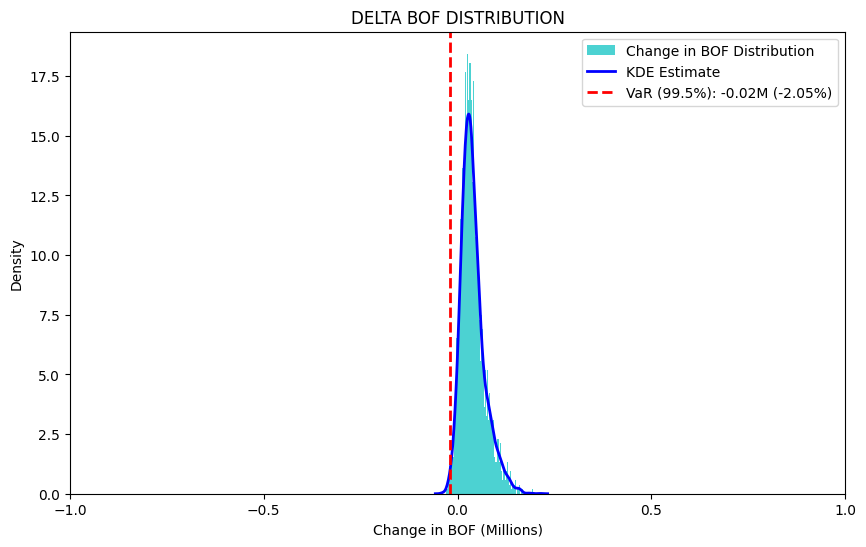

Date 2020-07-17 00:00:00: SCR = -20472.87928476333
Date 2020-07-20 00:00:00: SCR = -20604.58864841461
Date 2020-07-21 00:00:00: SCR = -19483.856426181792
Date 2020-07-22 00:00:00: SCR = -20169.24894503593
Date 2020-07-23 00:00:00: SCR = -22975.300439615246
Date 2020-07-24 00:00:00: SCR = -21960.092836256023
Date 2020-07-27 00:00:00: SCR = -20211.845618886946
Date 2020-07-28 00:00:00: SCR = -19965.549499540324
Date 2020-07-29 00:00:00: SCR = -21438.216486425397
Date 2020-07-30 00:00:00: SCR = -20829.680147552488
Date 2020-07-31 00:00:00: SCR = -20803.598681211468
Date 2020-08-03 00:00:00: SCR = -20658.15192229271
Date 2020-08-04 00:00:00: SCR = -19325.697066860183
Date 2020-08-05 00:00:00: SCR = -19810.47619310378
Date 2020-08-06 00:00:00: SCR = -20844.161942415238
Date 2020-08-07 00:00:00: SCR = -21071.07506776809
Date 2020-08-10 00:00:00: SCR = -21268.34487401008
Date 2020-08-11 00:00:00: SCR = -19992.547664928432
Date 2020-08-12 00:00:00: SCR = -20868.01619997978
Date 2020-08-13 00:0

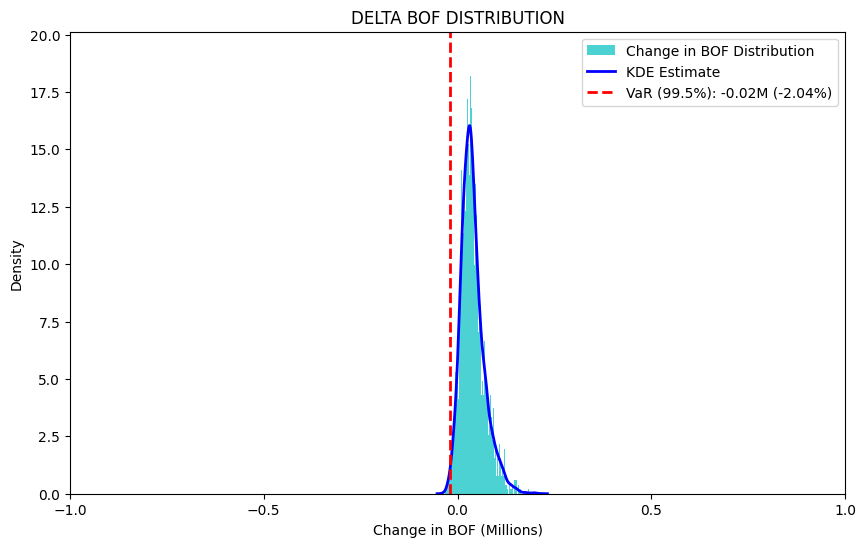

Date 2020-08-14 00:00:00: SCR = -20398.797705945963
Date 2020-08-17 00:00:00: SCR = -19841.121189565656
Date 2020-08-18 00:00:00: SCR = -21553.451496067046
Date 2020-08-19 00:00:00: SCR = -19572.457403230645
Date 2020-08-20 00:00:00: SCR = -19140.68718162536
Date 2020-08-21 00:00:00: SCR = -20319.500062112806
Date 2020-08-24 00:00:00: SCR = -20414.253708047847
Date 2020-08-25 00:00:00: SCR = -20254.372559347135
Date 2020-08-26 00:00:00: SCR = -20651.254194221492
Date 2020-08-27 00:00:00: SCR = -19977.55944743156
Date 2020-08-28 00:00:00: SCR = -20808.01193177223
Date 2020-08-31 00:00:00: SCR = -20344.958349208828
Date 2020-09-01 00:00:00: SCR = -20348.65059099197
Date 2020-09-02 00:00:00: SCR = -22775.58854229927
Date 2020-09-03 00:00:00: SCR = -22110.789888315194
Date 2020-09-04 00:00:00: SCR = -21120.864494628902
Date 2020-09-09 00:00:00: SCR = -20561.017184963224
Date 2020-09-10 00:00:00: SCR = -21693.668558778754
Date 2020-09-11 00:00:00: SCR = -18604.863376808164
Date 2020-09-14 0

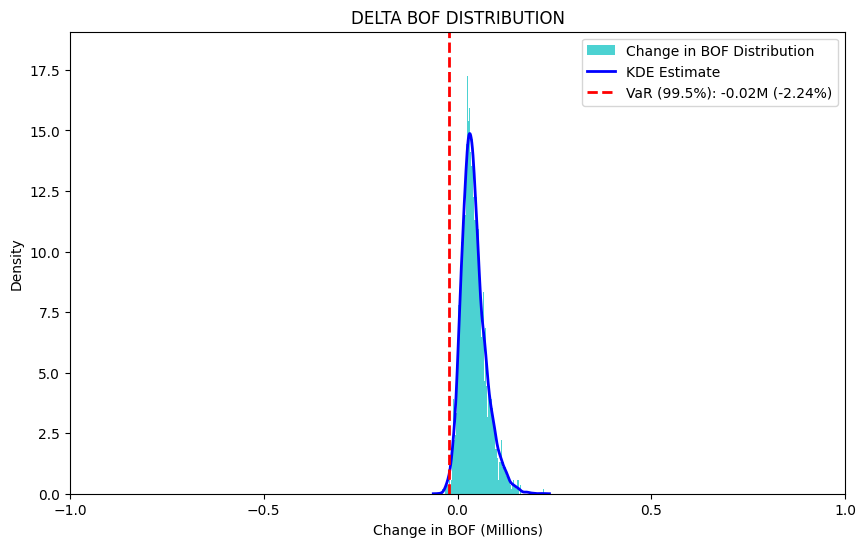

Date 2020-09-15 00:00:00: SCR = -22404.993733968735
Date 2020-09-16 00:00:00: SCR = -19082.107908458707
Date 2020-09-17 00:00:00: SCR = -19202.834840688683
Date 2020-09-18 00:00:00: SCR = -19152.144444265363
Date 2020-09-21 00:00:00: SCR = -18944.053193330765
Date 2020-09-22 00:00:00: SCR = -19046.16535384178
Date 2020-09-23 00:00:00: SCR = -20272.464072113034
Date 2020-09-24 00:00:00: SCR = -21975.632481613156
Date 2020-09-25 00:00:00: SCR = -19246.1736255455
Date 2020-09-28 00:00:00: SCR = -17439.868228149404
Date 2020-09-29 00:00:00: SCR = -18605.5225275421
Date 2020-09-30 00:00:00: SCR = -20006.174728736874
Date 2020-10-01 00:00:00: SCR = -20156.566614284515
Date 2020-10-02 00:00:00: SCR = -19800.743262567517
Date 2020-10-05 00:00:00: SCR = -19269.4604784584
Date 2020-10-06 00:00:00: SCR = -17526.914420433026
Date 2020-10-07 00:00:00: SCR = -19717.022190742464
Date 2020-10-08 00:00:00: SCR = -21341.627114448547
Date 2020-10-09 00:00:00: SCR = -18685.685467815398
Date 2020-10-12 00:

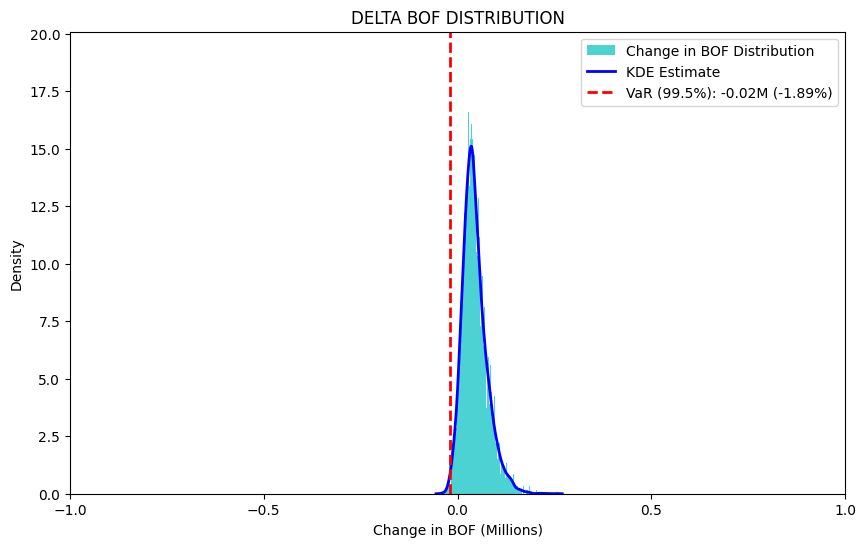

Date 2020-10-13 00:00:00: SCR = -18868.83837123869
Date 2020-10-14 00:00:00: SCR = -18746.44474617958
Date 2020-10-15 00:00:00: SCR = -18829.066529626834
Date 2020-10-16 00:00:00: SCR = -18564.13538087842
Date 2020-10-19 00:00:00: SCR = -19249.518244543073
Date 2020-10-20 00:00:00: SCR = -18687.07809121129
Date 2020-10-21 00:00:00: SCR = -19179.5503612709
Date 2020-10-22 00:00:00: SCR = -17384.765693426132
Date 2020-10-23 00:00:00: SCR = -17720.11246932029
Date 2020-10-26 00:00:00: SCR = -17330.174832286833
Date 2020-10-27 00:00:00: SCR = -17600.42623856543
Date 2020-10-28 00:00:00: SCR = -17777.515250387187
Date 2020-10-29 00:00:00: SCR = -19147.71313999176
Date 2020-10-30 00:00:00: SCR = -17295.595310792916
Date 2020-11-02 00:00:00: SCR = -17470.694537363044
Date 2020-11-03 00:00:00: SCR = -17336.04397622107
Date 2020-11-04 00:00:00: SCR = -15873.673598394374
Date 2020-11-05 00:00:00: SCR = -16278.300247592915
Date 2020-11-06 00:00:00: SCR = -18079.039757595056
Date 2020-11-09 00:00:

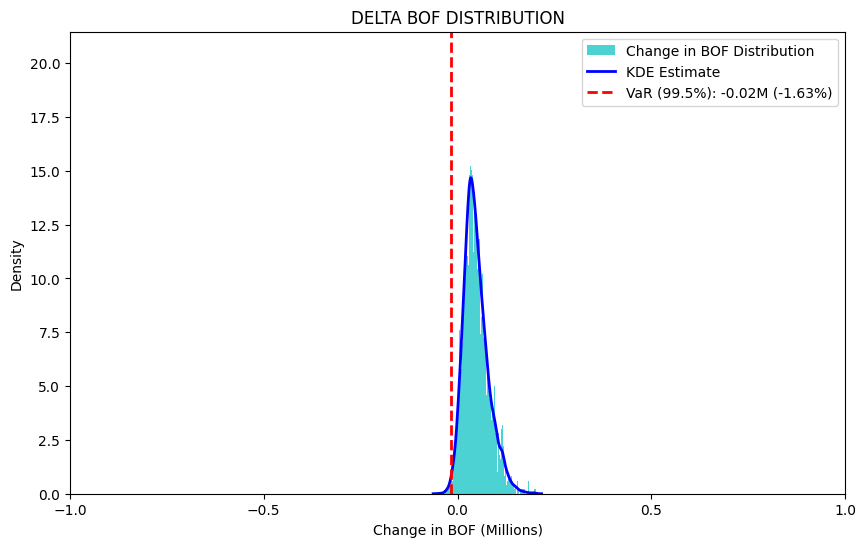

Date 2020-11-10 00:00:00: SCR = -16298.853700876229
Date 2020-11-11 00:00:00: SCR = -17979.717392854665
Date 2020-11-12 00:00:00: SCR = -17471.762022037503
Date 2020-11-13 00:00:00: SCR = -17219.241221885666
Date 2020-11-16 00:00:00: SCR = -16668.45880059242
Date 2020-11-17 00:00:00: SCR = -16578.48922496795
Date 2020-11-18 00:00:00: SCR = -17833.942297697064
Date 2020-11-19 00:00:00: SCR = -13543.788751010889
Date 2020-11-20 00:00:00: SCR = -14483.29514426231
Date 2020-11-23 00:00:00: SCR = -16271.687349309917
Date 2020-11-24 00:00:00: SCR = -16143.551533737182
Date 2020-11-25 00:00:00: SCR = -16662.698332347856
Date 2020-11-26 00:00:00: SCR = -14663.781411256787
Date 2020-11-27 00:00:00: SCR = -14612.92999199867
Date 2020-11-30 00:00:00: SCR = -14020.395652084351
Date 2020-12-01 00:00:00: SCR = -15498.78709431647
Date 2020-12-02 00:00:00: SCR = -17758.906427078244
Date 2020-12-03 00:00:00: SCR = -15353.854463243479
Date 2020-12-04 00:00:00: SCR = -16063.08670825958
Date 2020-12-07 00

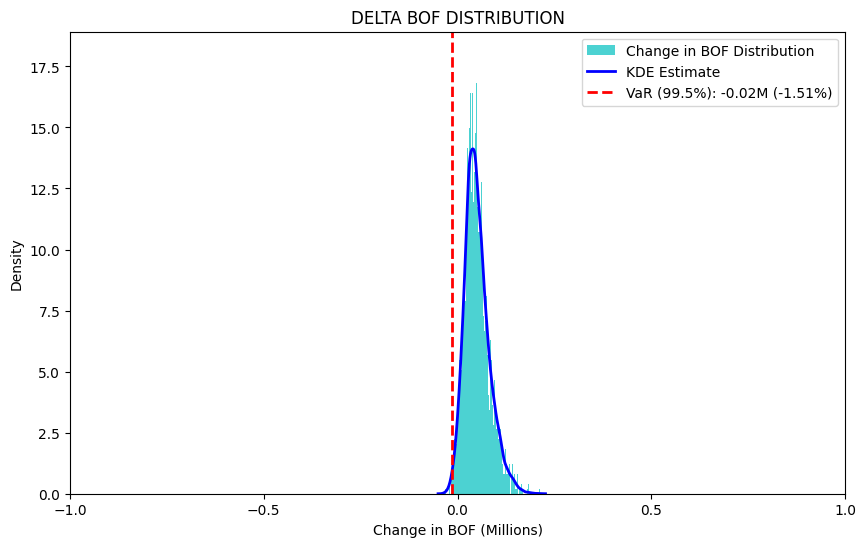

Date 2020-12-08 00:00:00: SCR = -15112.574625062938
Date 2020-12-09 00:00:00: SCR = -14933.824071817366
Date 2020-12-10 00:00:00: SCR = -14579.954366693497
Date 2020-12-11 00:00:00: SCR = -14125.237735471723
Date 2020-12-14 00:00:00: SCR = -15507.674279317855
Date 2020-12-15 00:00:00: SCR = -13809.860485658646
Date 2020-12-16 00:00:00: SCR = -14733.940235061624
Date 2020-12-17 00:00:00: SCR = -14440.35420475005
Date 2020-12-18 00:00:00: SCR = -13781.007709159836
Date 2020-12-21 00:00:00: SCR = -14308.100705623614
Date 2020-12-22 00:00:00: SCR = -14226.884486761091
Date 2020-12-23 00:00:00: SCR = -13029.305751981732
Date 2020-12-24 00:00:00: SCR = -14317.927223224639
Date 2020-12-28 00:00:00: SCR = -13996.95715323448
Date 2020-12-29 00:00:00: SCR = -12466.725333347313
Date 2020-12-30 00:00:00: SCR = -13429.514556837068
Date 2020-12-31 00:00:00: SCR = -13165.198435163496
Date 2021-01-04 00:00:00: SCR = -14179.19680063245
Date 2021-01-05 00:00:00: SCR = -11861.964516477572
Date 2021-01-06

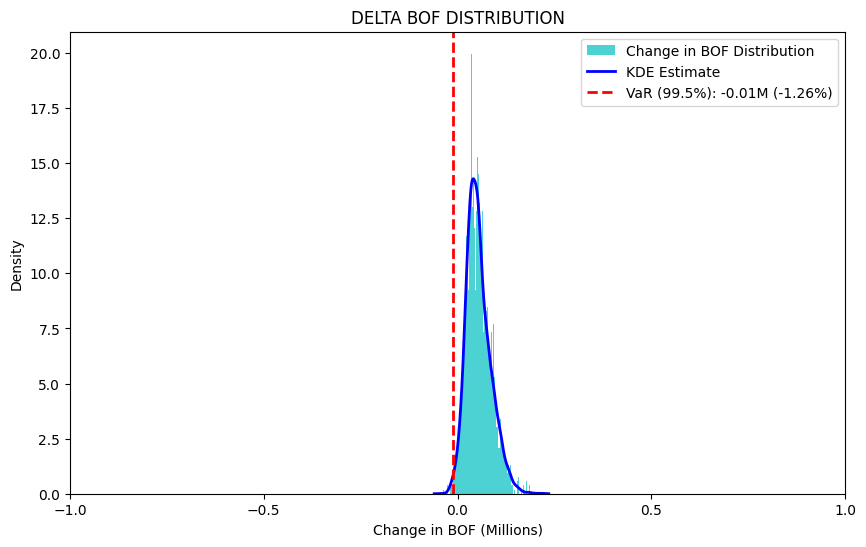

Date 2021-01-07 00:00:00: SCR = -12621.268130941386
Date 2021-01-08 00:00:00: SCR = -12131.041603298168
Date 2021-01-11 00:00:00: SCR = -13429.051269035332
Date 2021-01-12 00:00:00: SCR = -10131.175920934667
Date 2021-01-13 00:00:00: SCR = -10033.473205604532
Date 2021-01-14 00:00:00: SCR = -11050.247339134216
Date 2021-01-15 00:00:00: SCR = -10886.379580574023
Date 2021-01-18 00:00:00: SCR = -10289.31743139266
Date 2021-01-19 00:00:00: SCR = -11304.997189683898
Date 2021-01-20 00:00:00: SCR = -13261.510862550733
Date 2021-01-21 00:00:00: SCR = -9719.751216058728
Date 2021-01-22 00:00:00: SCR = -8971.153087072373
Date 2021-01-25 00:00:00: SCR = -8936.802676134093
Date 2021-01-26 00:00:00: SCR = -8812.702827033982
Date 2021-01-27 00:00:00: SCR = -8838.03501706122
Date 2021-01-28 00:00:00: SCR = -9732.356079216002
Date 2021-01-29 00:00:00: SCR = -9208.952100248334
Date 2021-02-01 00:00:00: SCR = -7659.52763317108
Date 2021-02-02 00:00:00: SCR = -5957.068479576105
Date 2021-02-03 00:00:00

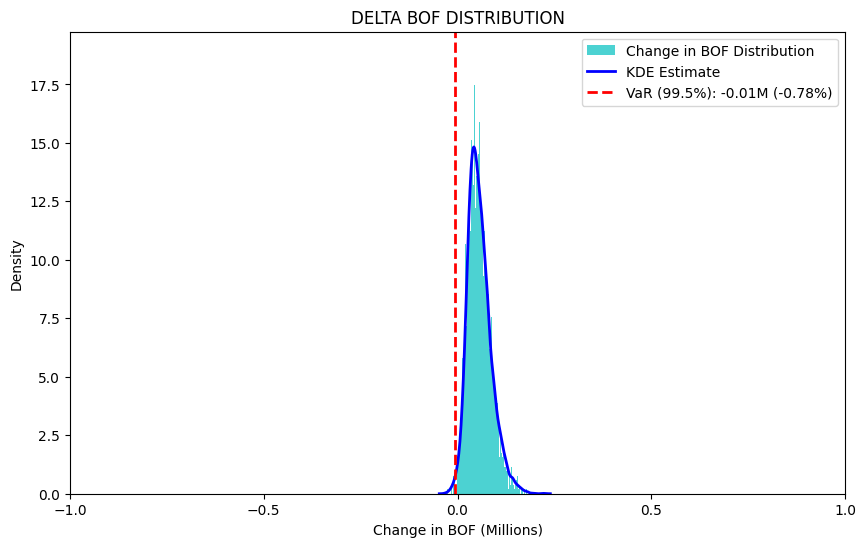

Date 2021-02-04 00:00:00: SCR = -7795.213090810775
Date 2021-02-05 00:00:00: SCR = -7270.934129390716
Date 2021-02-08 00:00:00: SCR = -5838.595043716427
Date 2021-02-09 00:00:00: SCR = -6251.357022848115
Date 2021-02-10 00:00:00: SCR = -4493.003774147029
Date 2021-02-11 00:00:00: SCR = -5446.810599575042
Date 2021-02-12 00:00:00: SCR = -5447.4094068431805
Date 2021-02-15 00:00:00: SCR = -5341.1682873821255
Date 2021-02-16 00:00:00: SCR = -3406.6369508552502
Date 2021-02-17 00:00:00: SCR = -2752.305877628318
Date 2021-02-18 00:00:00: SCR = -2575.7299196338568
Date 2021-02-19 00:00:00: SCR = -1203.809533309923
Date 2021-02-22 00:00:00: SCR = -731.5062682914707
Date 2021-02-23 00:00:00: SCR = -508.2910459041484
Date 2021-02-24 00:00:00: SCR = 1969.7212028598808
Date 2021-02-25 00:00:00: SCR = 3990.031482477196
Date 2021-02-26 00:00:00: SCR = 2754.9223427295697
Date 2021-03-01 00:00:00: SCR = 1696.1138566780116
Date 2021-03-02 00:00:00: SCR = 3925.7463064193903
Date 2021-03-03 00:00:00: SC

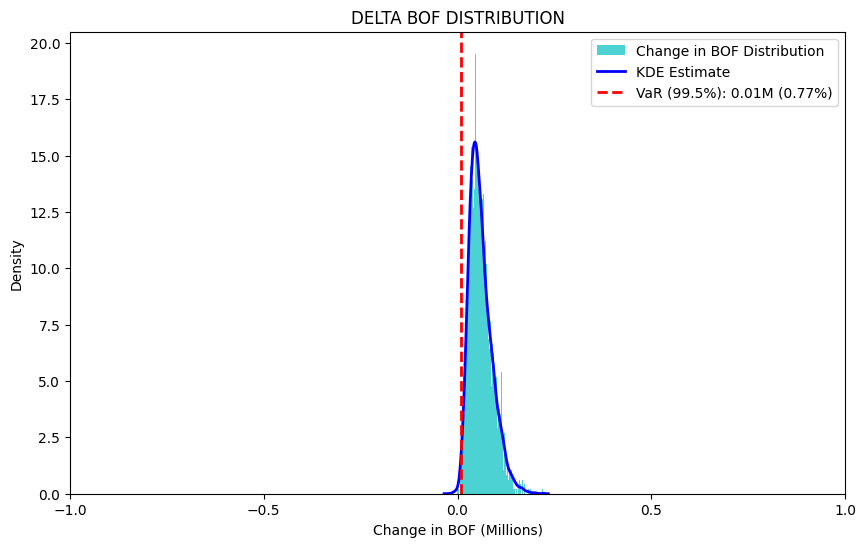

Date 2021-03-04 00:00:00: SCR = 7709.6479854583795
Date 2021-03-05 00:00:00: SCR = 7003.534858751297
Date 2021-03-08 00:00:00: SCR = 6164.878140115743
Date 2021-03-09 00:00:00: SCR = 8044.039453439721
Date 2021-03-10 00:00:00: SCR = 7879.383788328172
Date 2021-03-11 00:00:00: SCR = 8644.00269564629
Date 2021-03-12 00:00:00: SCR = 8905.540555963518
Date 2021-03-15 00:00:00: SCR = 7729.030614213945
Date 2021-03-16 00:00:00: SCR = 7663.12474299433
Date 2021-03-17 00:00:00: SCR = 7885.189075250626
Date 2021-03-18 00:00:00: SCR = 5235.447609043126
Date 2021-03-19 00:00:00: SCR = 6645.692133436205
Date 2021-03-22 00:00:00: SCR = 4876.339439411164
Date 2021-03-23 00:00:00: SCR = 4420.548547115329
Date 2021-03-24 00:00:00: SCR = 4315.677102518083
Date 2021-03-25 00:00:00: SCR = 1535.7134893226632
Date 2021-03-26 00:00:00: SCR = 3979.3796785450104
Date 2021-03-29 00:00:00: SCR = 2625.7162495231632
Date 2021-03-30 00:00:00: SCR = 2384.8470730113986
Date 2021-03-31 00:00:00: SCR = 3017.4628996086

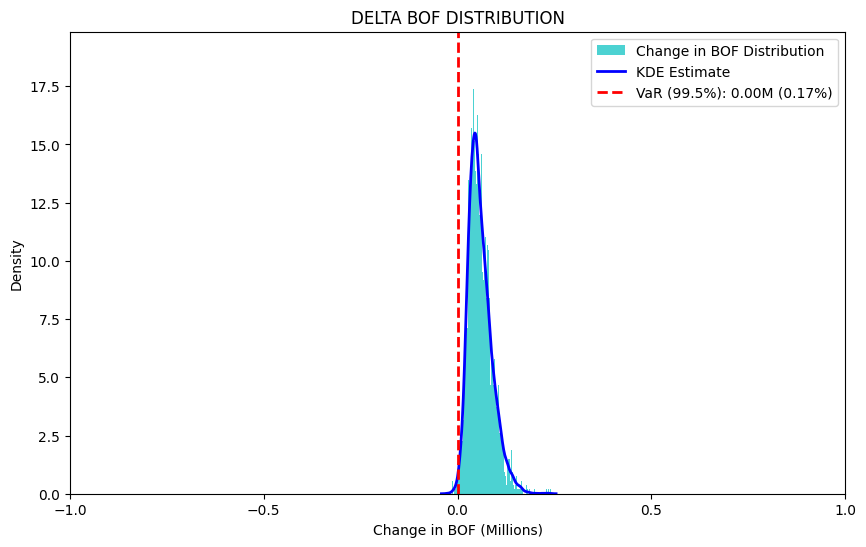

Date 2021-04-01 00:00:00: SCR = 1691.165584621435
Date 2021-04-06 00:00:00: SCR = 1207.4386166191118
Date 2021-04-07 00:00:00: SCR = 972.7755740070388
Date 2021-04-08 00:00:00: SCR = 1475.0731248188072
Date 2021-04-09 00:00:00: SCR = 3.798330144889675
Date 2021-04-12 00:00:00: SCR = 252.40293935776307
Date 2021-04-13 00:00:00: SCR = -1471.5649294280945
Date 2021-04-14 00:00:00: SCR = 358.20034702301865
Date 2021-04-15 00:00:00: SCR = -2842.7630152320853
Date 2021-04-16 00:00:00: SCR = -2910.157642040242
Date 2021-04-19 00:00:00: SCR = -3777.4042487907336
Date 2021-04-20 00:00:00: SCR = -4348.037075281137
Date 2021-04-21 00:00:00: SCR = -4627.729213724132
Date 2021-04-22 00:00:00: SCR = -2654.042855806345
Date 2021-04-23 00:00:00: SCR = -5533.109629640568
Date 2021-04-26 00:00:00: SCR = -6206.514030227656
Date 2021-04-27 00:00:00: SCR = -6652.6536444473195
Date 2021-04-28 00:00:00: SCR = -6285.943027801505
Date 2021-04-29 00:00:00: SCR = -7140.504713430387
Date 2021-04-30 00:00:00: SCR 

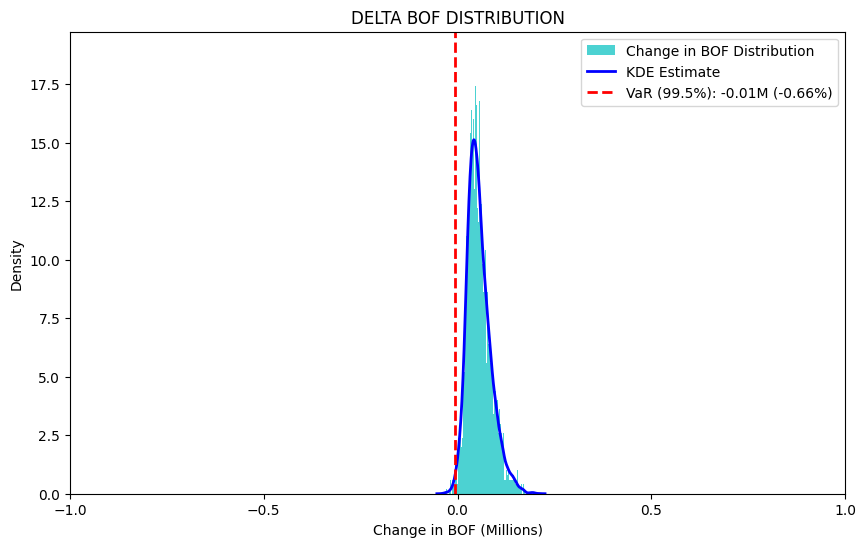

Date 2021-05-03 00:00:00: SCR = -6604.207448453882
Date 2021-05-04 00:00:00: SCR = -9022.656397342678
Date 2021-05-05 00:00:00: SCR = -5885.623315191262
Date 2021-05-06 00:00:00: SCR = -7227.639988613125
Date 2021-05-07 00:00:00: SCR = -9741.675319108954
Date 2021-05-10 00:00:00: SCR = -9855.094859533305
Date 2021-05-11 00:00:00: SCR = -10562.555037136073
Date 2021-05-12 00:00:00: SCR = -11734.010207767484
Date 2021-05-13 00:00:00: SCR = -10378.480159683228
Date 2021-05-14 00:00:00: SCR = -8536.698252763743
Date 2021-05-17 00:00:00: SCR = -11614.26978937149
Date 2021-05-18 00:00:00: SCR = -11920.832826309203
Date 2021-05-19 00:00:00: SCR = -10706.992648019788
Date 2021-05-20 00:00:00: SCR = -10477.000589551915
Date 2021-05-21 00:00:00: SCR = -10851.06332578659
Date 2021-05-24 00:00:00: SCR = -11541.299925756448
Date 2021-05-25 00:00:00: SCR = -11696.282125864027
Date 2021-05-26 00:00:00: SCR = -9980.468941373825
Date 2021-05-27 00:00:00: SCR = -11754.52225522995
Date 2021-05-28 00:00:0

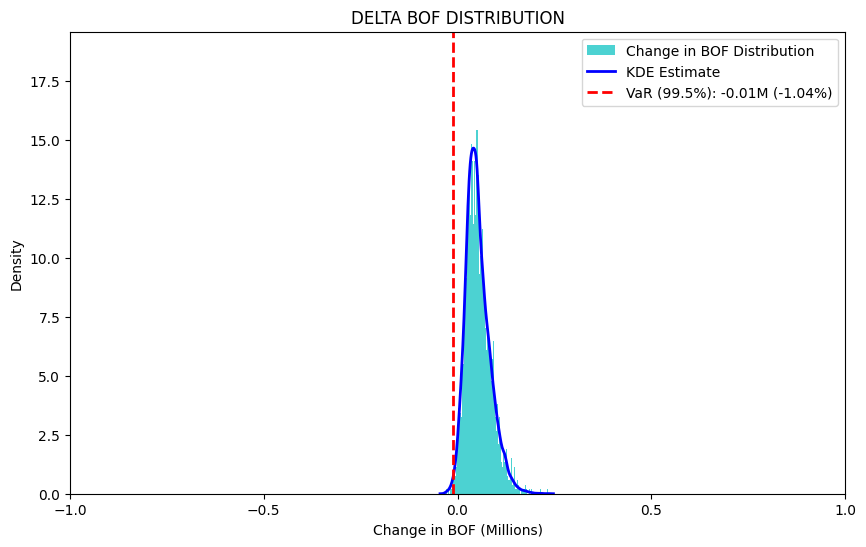

Date 2021-05-31 00:00:00: SCR = -10420.373801527014
Date 2021-06-01 00:00:00: SCR = -10628.97866416931
Date 2021-06-02 00:00:00: SCR = -12711.248581237782
Date 2021-06-03 00:00:00: SCR = -12029.912471628186
Date 2021-06-04 00:00:00: SCR = -12191.126718988407
Date 2021-06-07 00:00:00: SCR = -11764.605672655105
Date 2021-06-08 00:00:00: SCR = -14743.352114763256
Date 2021-06-09 00:00:00: SCR = -13906.53674295425
Date 2021-06-10 00:00:00: SCR = -12943.320035648341
Date 2021-06-11 00:00:00: SCR = -13508.037731246945
Date 2021-06-14 00:00:00: SCR = -13541.250255308143
Date 2021-06-15 00:00:00: SCR = -13295.616618909835
Date 2021-06-16 00:00:00: SCR = -14558.54062434196
Date 2021-06-17 00:00:00: SCR = -13468.549599313725
Date 2021-06-18 00:00:00: SCR = -15803.609587526313
Date 2021-06-21 00:00:00: SCR = -14210.758139419544
Date 2021-06-22 00:00:00: SCR = -15074.930256366722
Date 2021-06-23 00:00:00: SCR = -16167.682178401932
Date 2021-06-24 00:00:00: SCR = -15160.750257692334
Date 2021-06-25

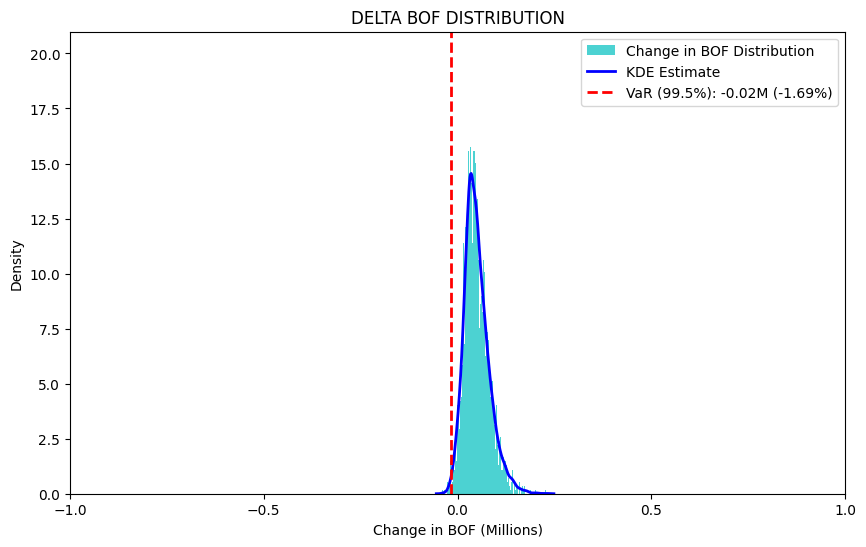

Date 2021-06-28 00:00:00: SCR = -16924.368077592848
Date 2021-06-29 00:00:00: SCR = -15251.525204935062
Date 2021-06-30 00:00:00: SCR = -16212.612223768225
Date 2021-07-01 00:00:00: SCR = -15725.582519655221
Date 2021-07-02 00:00:00: SCR = -16339.605619621268
Date 2021-07-05 00:00:00: SCR = -15626.81298819541
Date 2021-07-06 00:00:00: SCR = -16409.622617034904
Date 2021-07-07 00:00:00: SCR = -14689.568339643474
Date 2021-07-08 00:00:00: SCR = -16722.156527109142
Date 2021-07-09 00:00:00: SCR = -14402.356992673871
Date 2021-07-12 00:00:00: SCR = -15562.08400491714
Date 2021-07-13 00:00:00: SCR = -17888.51036082267
Date 2021-07-14 00:00:00: SCR = -16952.900054121
Date 2021-07-15 00:00:00: SCR = -16106.775183792113
Date 2021-07-16 00:00:00: SCR = -15256.479523487089
Date 2021-07-19 00:00:00: SCR = -18719.680858058928
Date 2021-07-20 00:00:00: SCR = -16358.26511298179
Date 2021-07-21 00:00:00: SCR = -16133.292890367507
Date 2021-07-22 00:00:00: SCR = -18117.976260147083
Date 2021-07-23 00:

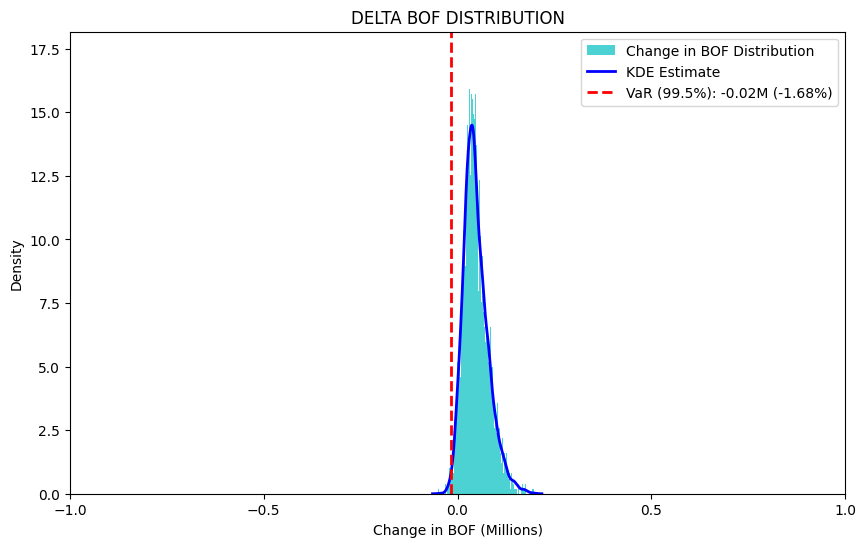

Date 2021-07-26 00:00:00: SCR = -16770.195855569833
Date 2021-07-27 00:00:00: SCR = -15699.82043334007


In [56]:
asset_names = list(returns_df.columns)

from utilities.bof_var_plot import plot_bof_var

# scenarios_results is assumed to be a nested dictionary:
# { asset_name: { date: scenarios_array, ... }, ... }
# where scenarios_array has shape (n_simulations, window_size)
#
# We want to build a matrix for each date of shape (n_simulations, n_assets),
# where each column is the last value (i.e. cumulative return) from the corresponding asset’s scenarios.

# Get the list of dates for which we have generated scenarios.
# (Assuming the dates are the same across assets, here we take the dates from the first asset.)
all_dates = sorted(list(scenarios_results[asset_names[0]].keys()))

# Dictionary to store SCR for each date.
portfolio_scr_results = {}  # key: date, value: scr

i = 0
for date in all_dates[:]:
    i += 1
    gan_samples_cols = []
    for asset in asset_names:
        # Retrieve the scenarios for the asset at this date.
        asset_scenarios = scenarios_results[asset][date]  # expected shape: (n_simulations, window_size)
        # Use the last column to represent the cumulative return.
        asset_cum = np.prod(1 + asset_scenarios, axis=1) - 1
        if np.isnan(asset_cum).any() or np.isinf(asset_cum).any():
            print(f"Warning: NaN or Inf encountered in cumulative returns for asset {asset} on date {date}.")
        gan_samples_cols.append(asset_cum.reshape(-1, 1))

    # Stack horizontally so that each column corresponds to one asset.
    gan_samples = np.hstack(gan_samples_cols)  # shape: (n_simulations, n_assets)
    
    # Create a portfolio with the aggregated GAN samples and the specified weights.

    bof_0_case_i = bof.iloc[bof.index.get_loc(date) - 252]

    portfolio = SimpleGANPortfolio(gan_samples, weights, bof0_casei=bof_0_case_i)
    bof_change, scr = portfolio.calculate_distribution_and_scr(case=2)

    if i % 20 == 0 or i == 1:
        plot_bof_var(bof_change,scr,"DELTA BOF DISTRIBUTION")
    
    portfolio_scr_results[date] = scr
    print(f"Date {date}: SCR = {scr}")


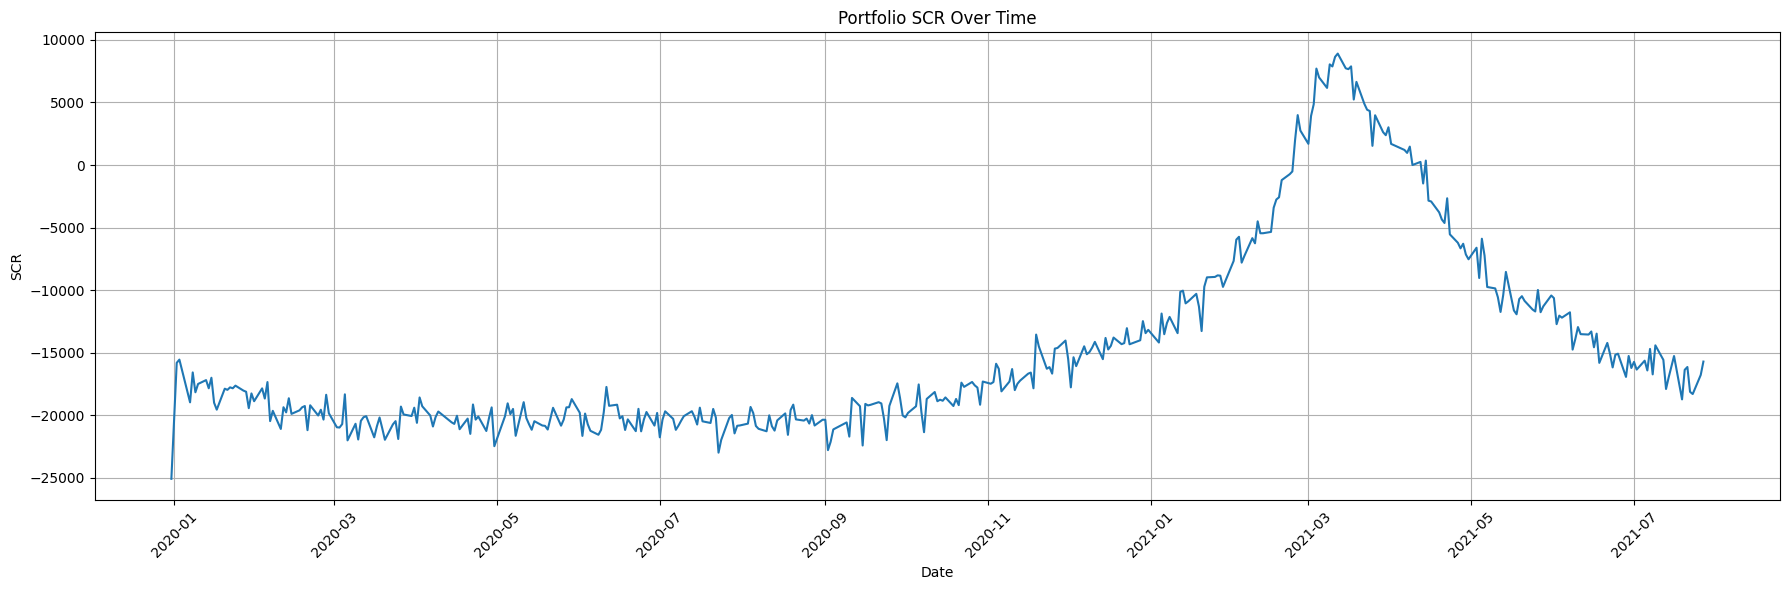

In [57]:
# Assume portfolio_scr_results is a dictionary with dates as keys and SCR values as values.
# First, sort the dates (this assumes the keys are either datetime objects or strings that sort chronologically)
sorted_dates = sorted(portfolio_scr_results.keys())
scr_values = [portfolio_scr_results[date] for date in sorted_dates]

plt.figure(figsize=(18, 6))
plt.plot(sorted_dates, scr_values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("SCR")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Try out exponential weighting.

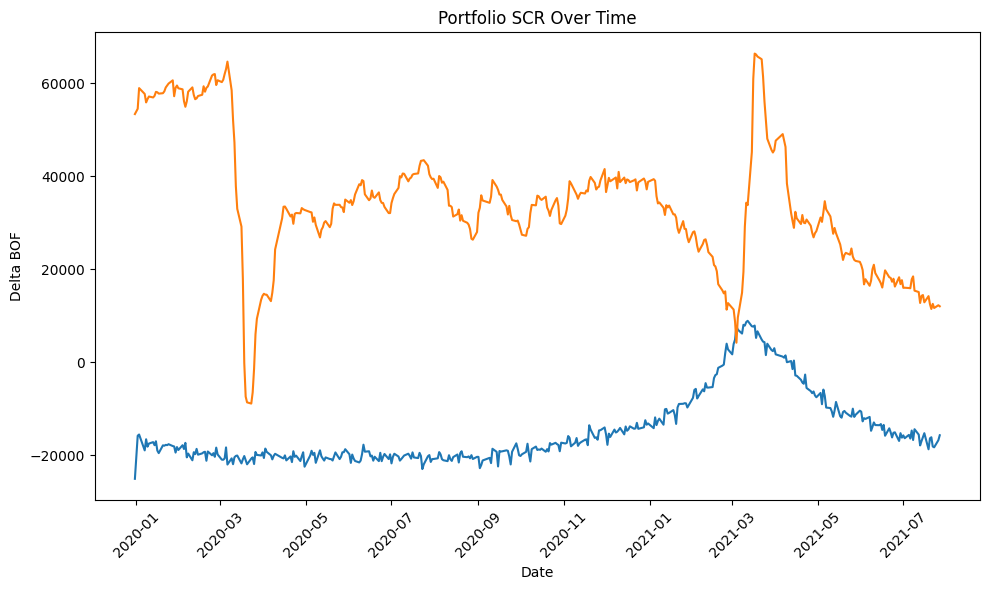

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(sorted_dates, scr_values, linestyle='-')
plt.plot(rolling_delta_bof.index, rolling_delta_bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Delta BOF")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

## RESULTS

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_IG_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_CGAN_output_test\generated_returns_EONIA_final_scenarios.pt
Scaled = False


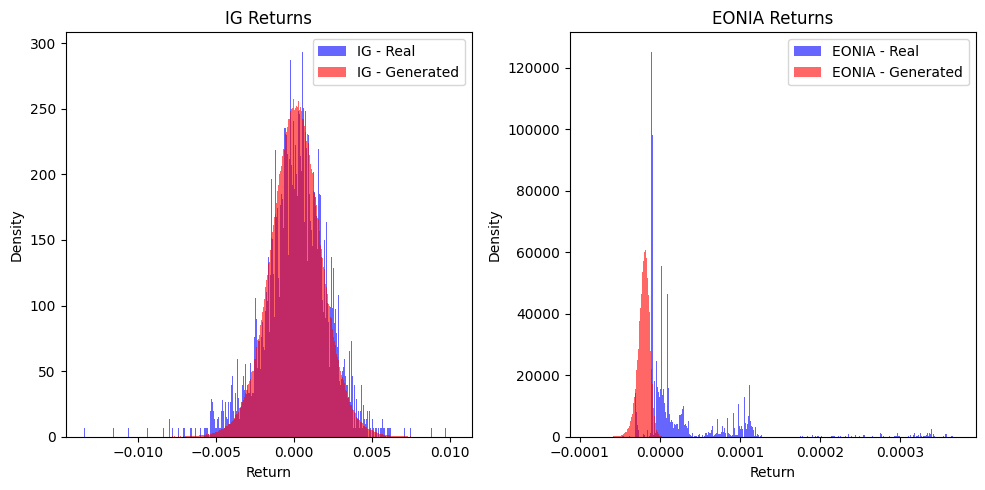


📊 Return Statistics Summary:
            Asset      Mean  Std Dev  Skewness  Kurtosis  99.5% VaR
        IG - Real  0.000182 0.002083 -0.458256  2.226597  -0.006788
   IG - Generated  0.000160 0.001670 -0.017075  0.561583  -0.004486
     EONIA - Real  0.000032 0.000069  2.682698  8.158064  -0.000031
EONIA - Generated -0.000020 0.000007 -0.667950  1.365160  -0.000044



═════════════════════════
║  ANALYZING ASSET: IG  ║
═════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_IG_final_scenarios.pt
Variance of Real Data: 0.000004
Variance of Generated Data: 0.000002
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.046002
Mean Pairwise Distance (Generated): 0.033203
✅ Generated samples are reasonably diverse


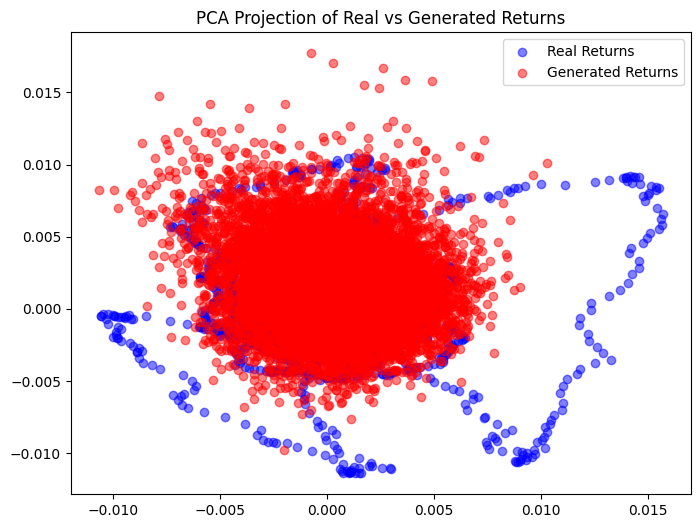

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_IG_final_scenarios.pt


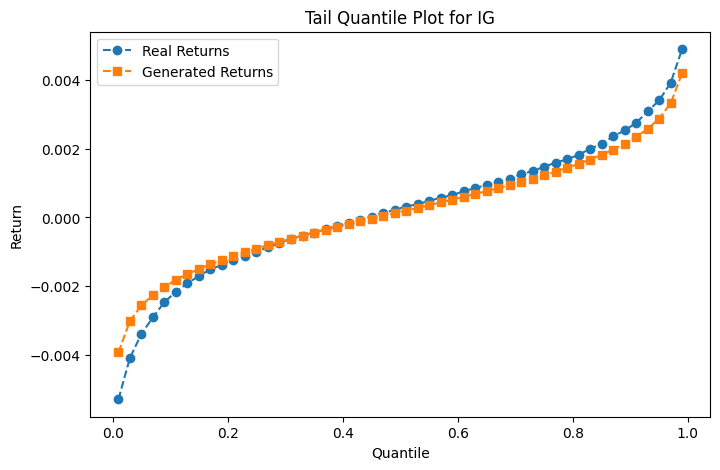


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: IG  ║
══════════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_IG_final_scenarios.pt

📊 Distance Summary for IG:
Min Distance: 0.000000
Max Distance: 2.230082
Mean Distance: 0.001266
Median Distance: 0.000375
Standard Deviation: 0.007740


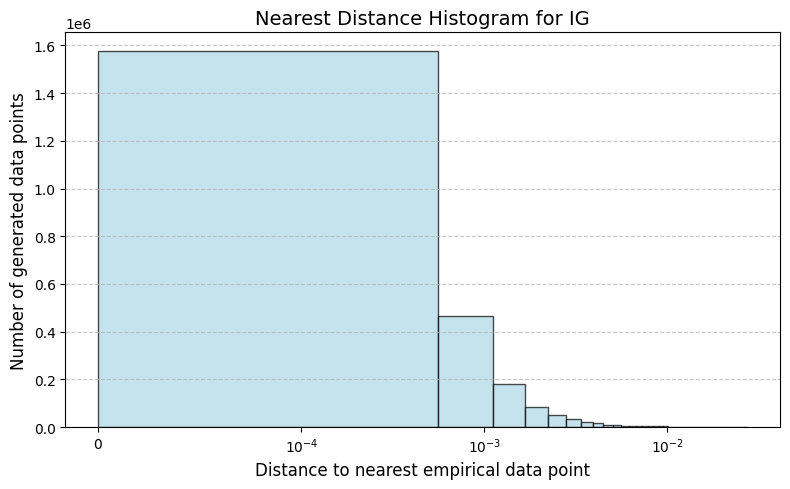


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: IG  ║
════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_IG_final_scenarios.pt
📊 Wasserstein Distance for IG: 0.000277


════════════════════════════
║  ANALYZING ASSET: EONIA  ║
════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_EONIA_final_scenarios.pt
Variance of Real Data: 0.000000
Variance of Generated Data: 0.000000
⚠️ Warning: Possible Mode Collapse - Low Variance in Generated Data
Mean Pairwise Distance (Real): 0.001171
Mean Pairwise Distance (Generated): 0.000150
⚠️ Warning: Potential Mode Collapse - Samples are too similar


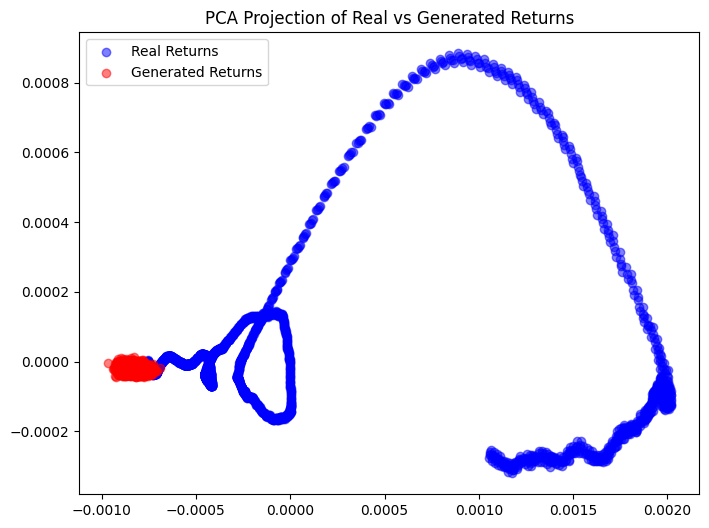


═══════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: EONIA  ║
═══════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_EONIA_final_scenarios.pt
📊 Wasserstein Distance for EONIA: 0.000052



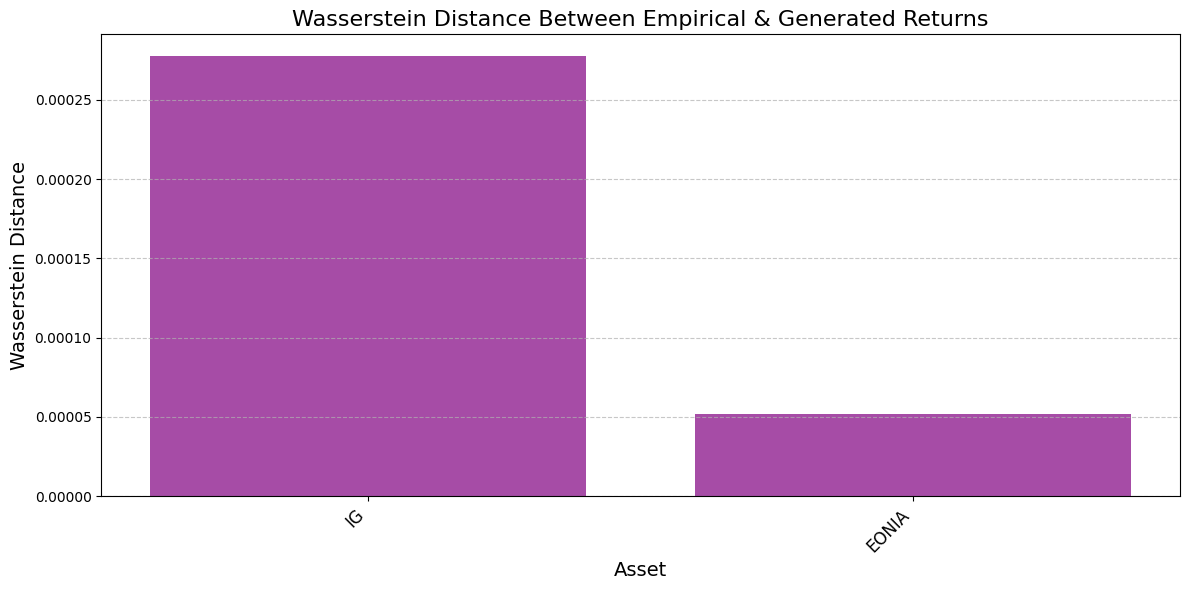

In [59]:
extensive_plotting(scaled=False, returns_df=returns_df, test=True, quarterly=False)

# ----------------------------------------------------------

In [106]:
from internal_models.GANs.explainability.visuals_3 import *
from internal_models.GANs.explainability.gan_visuals import *

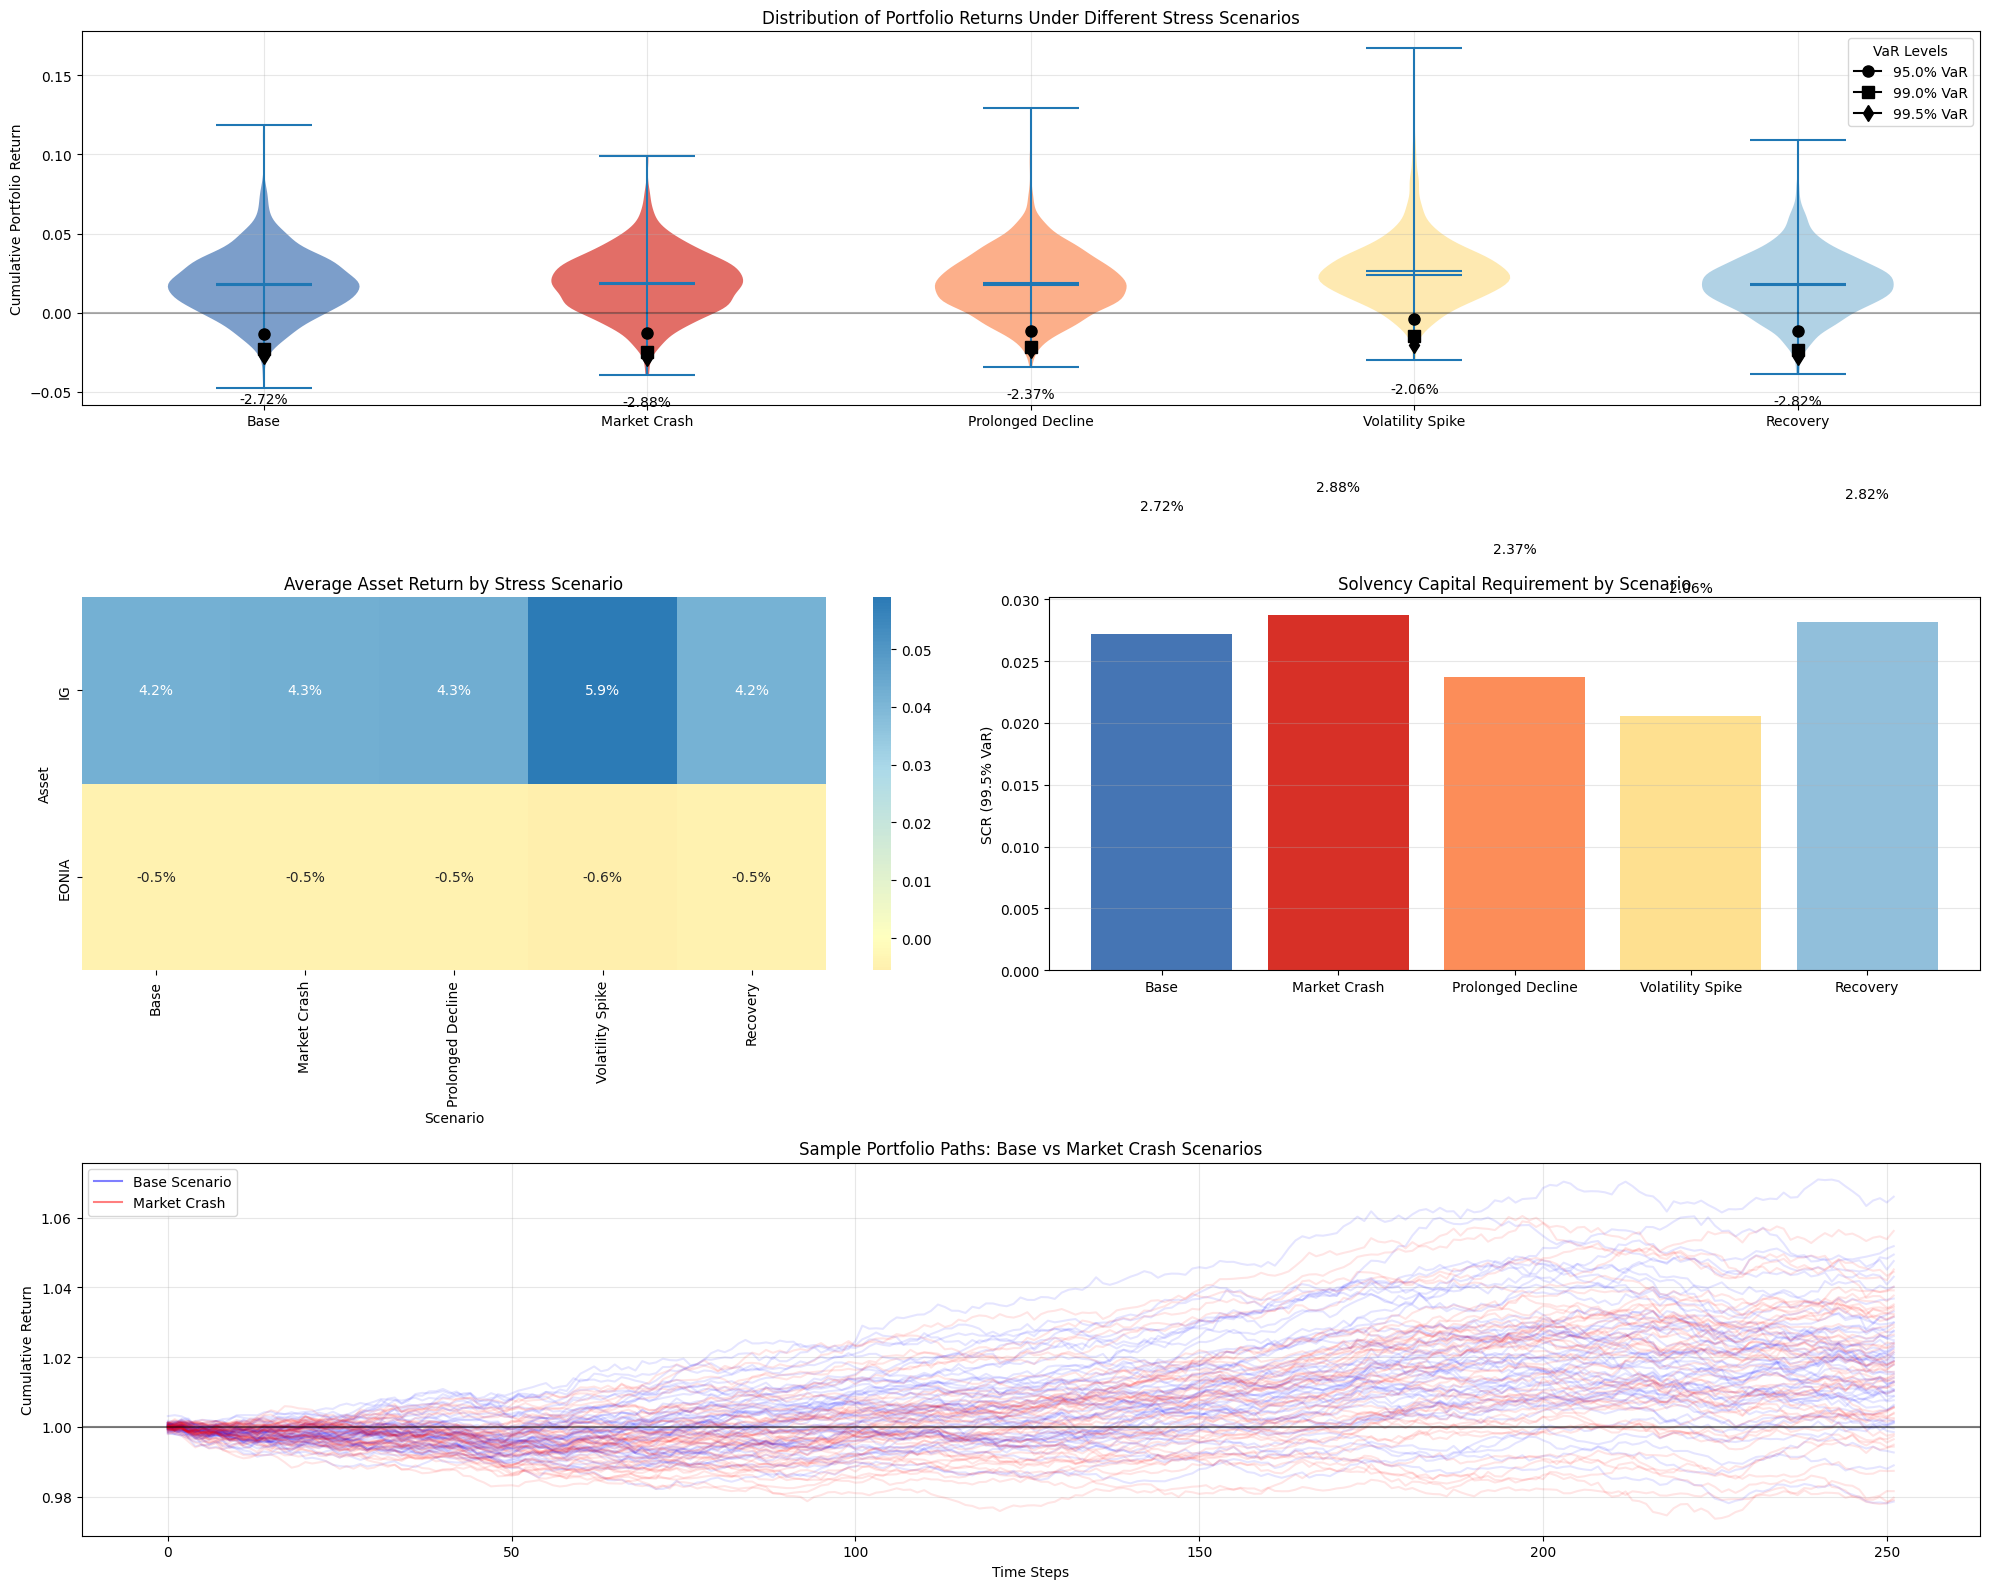

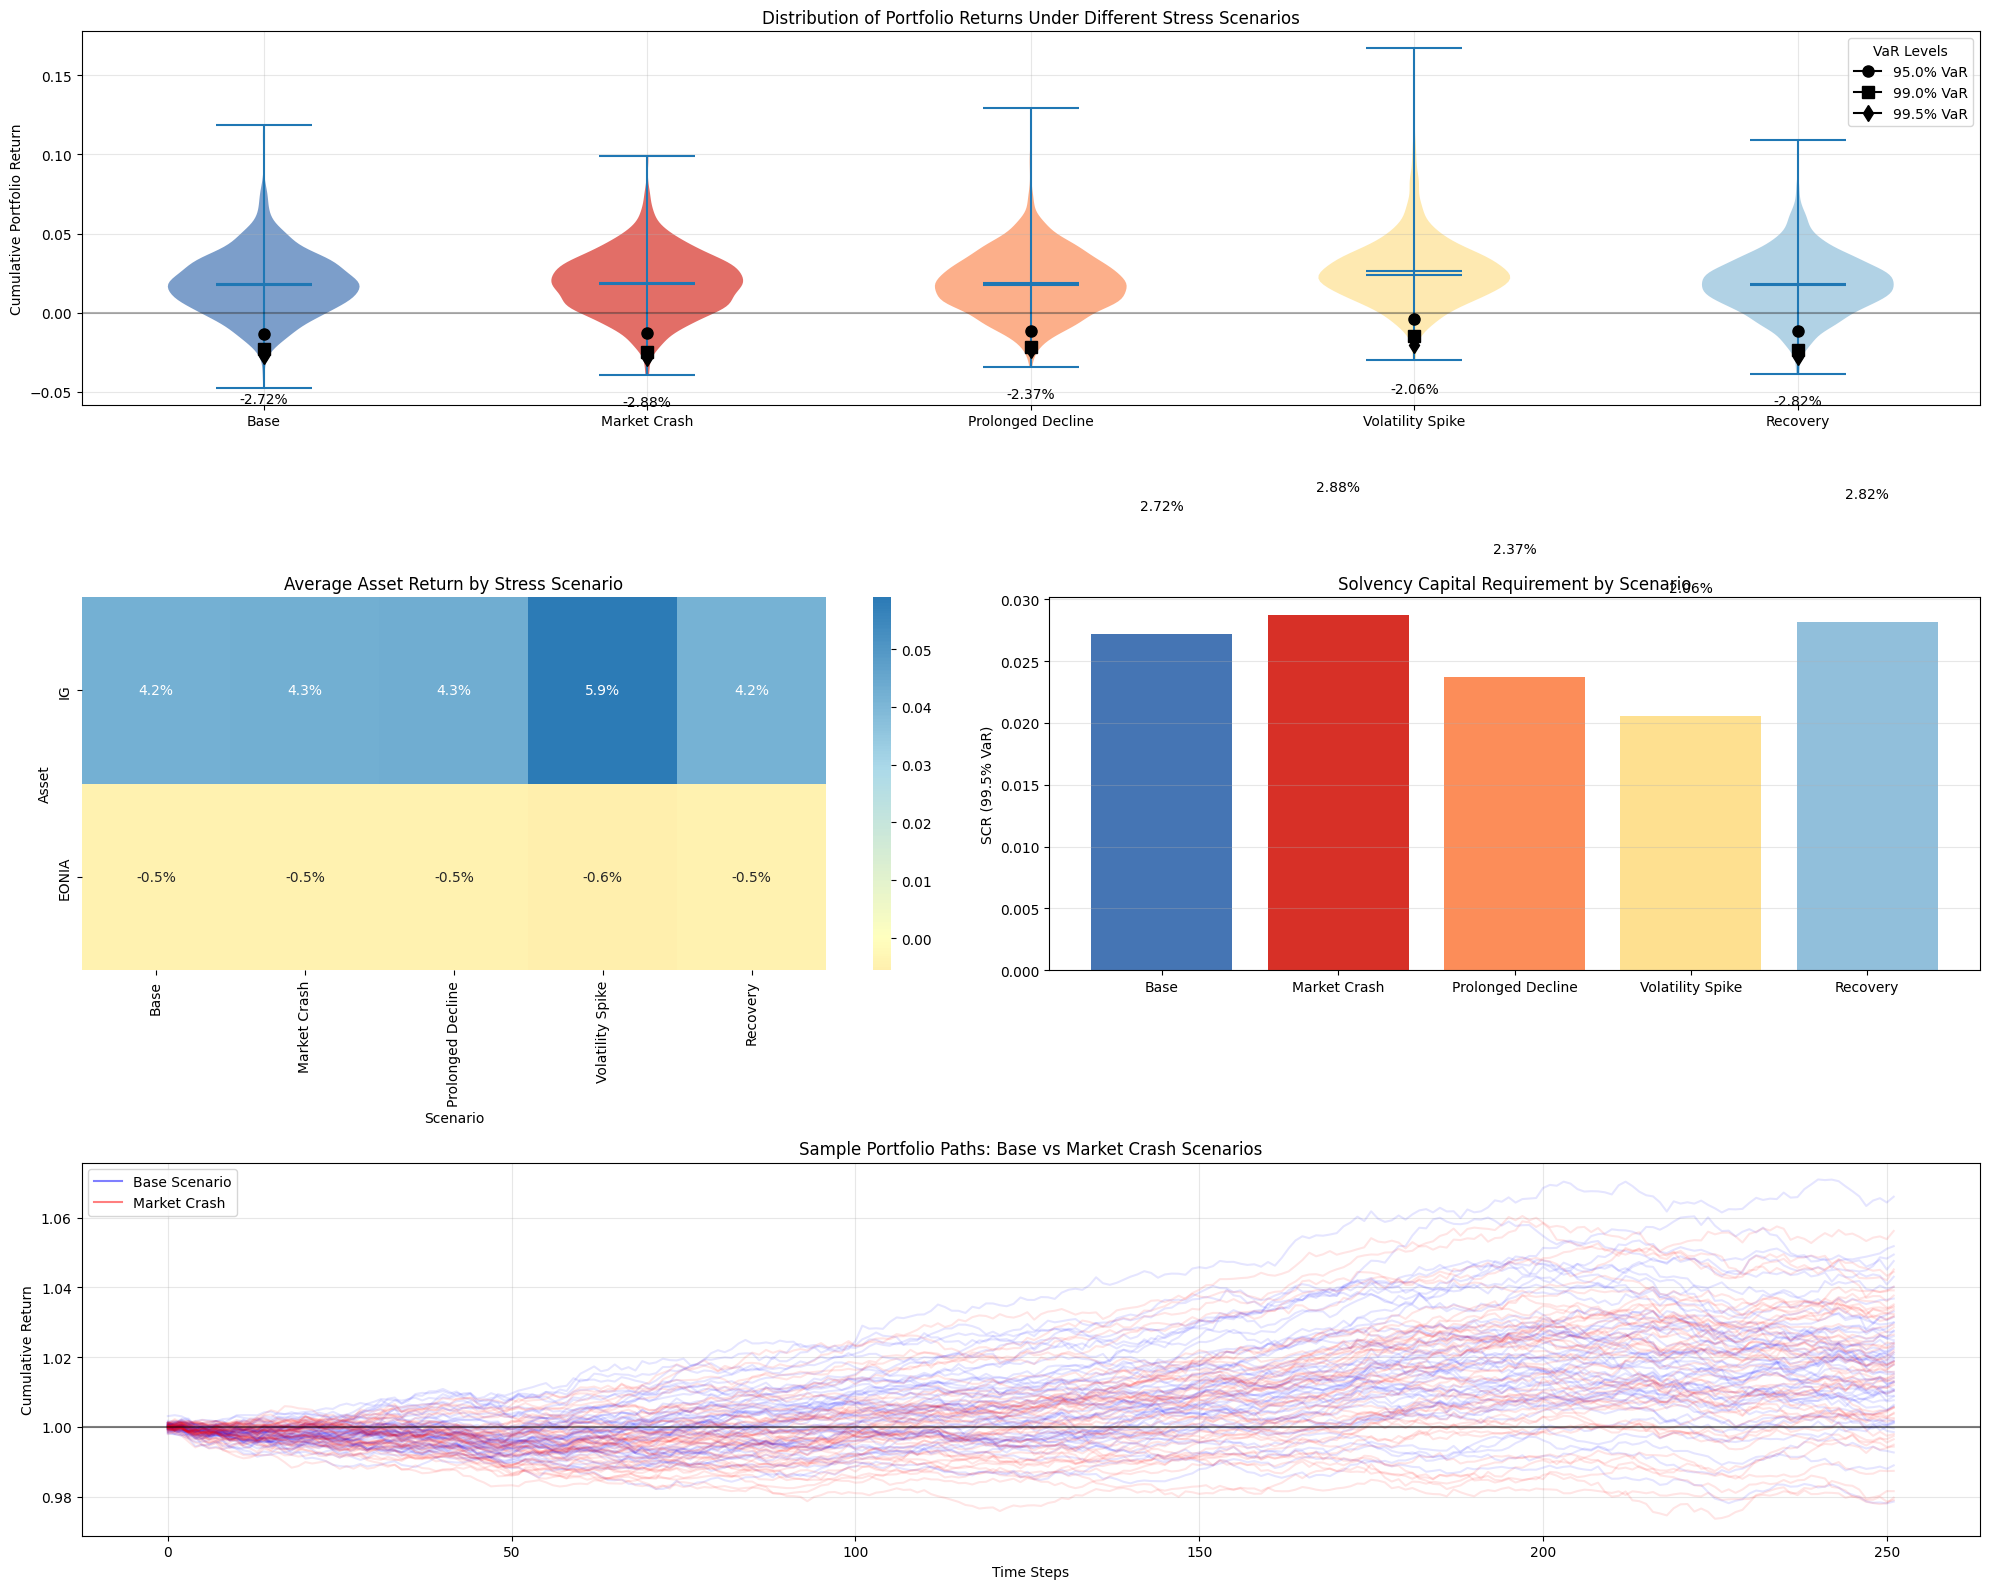

In [107]:
visualize_stress_tests(gan_dict)

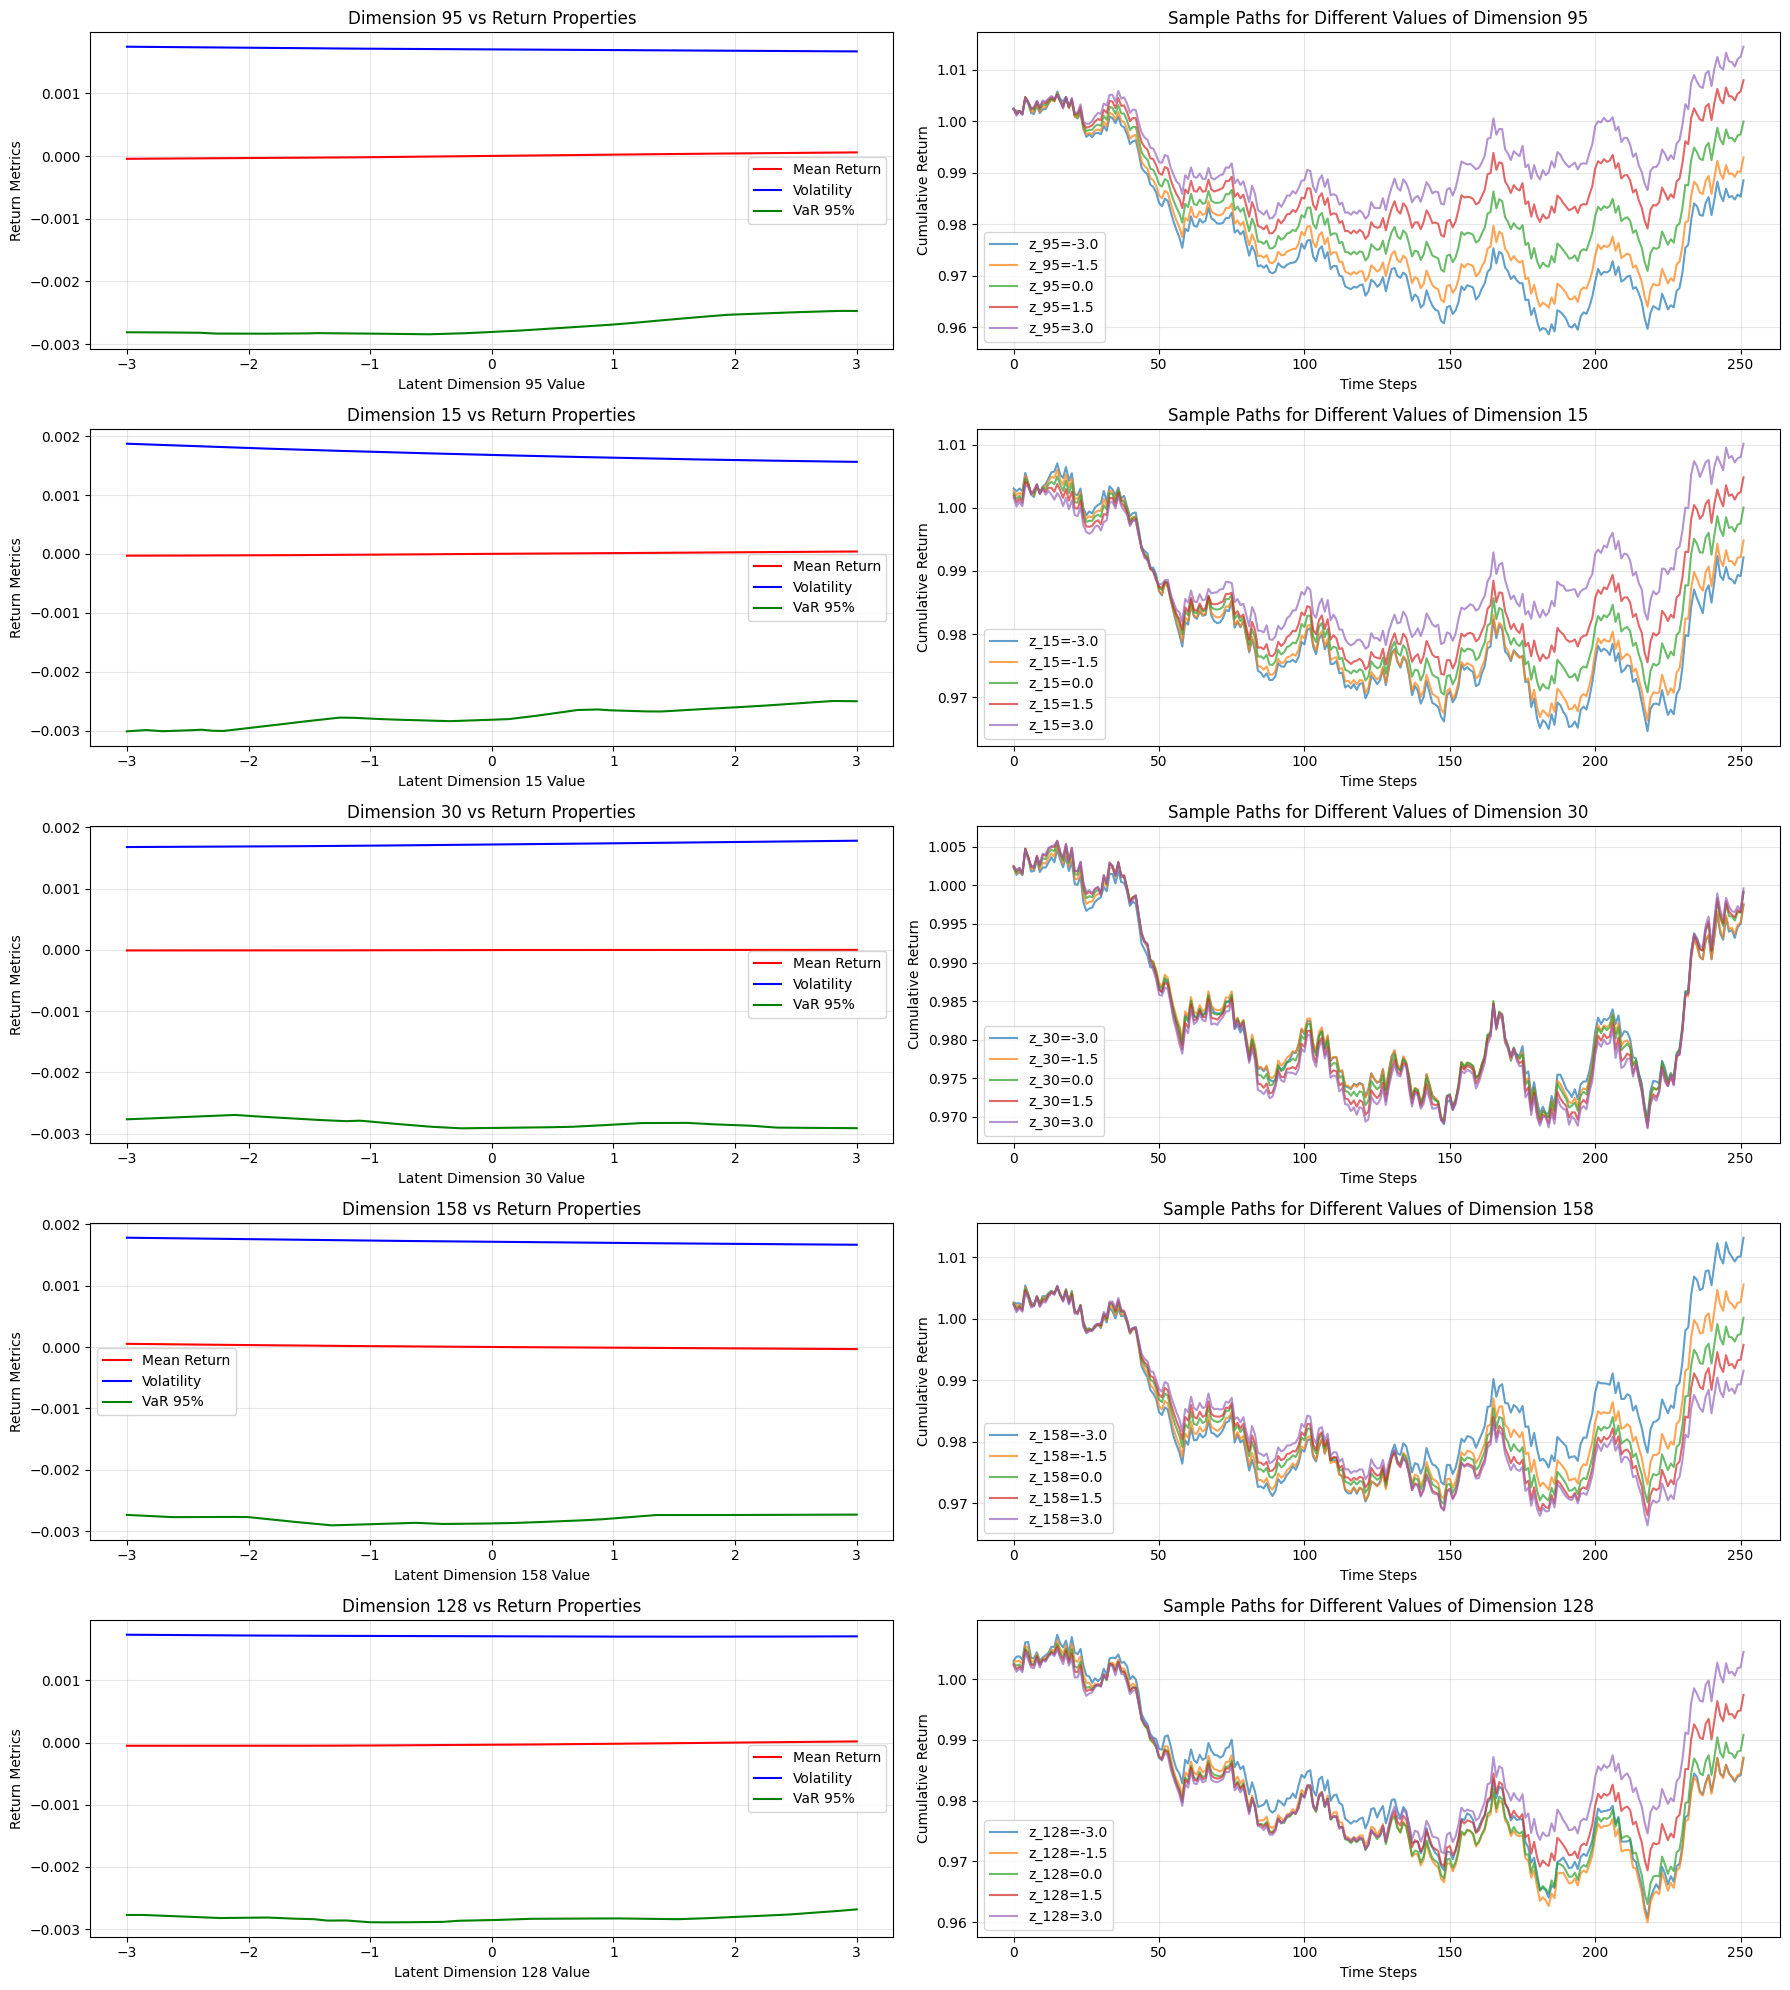

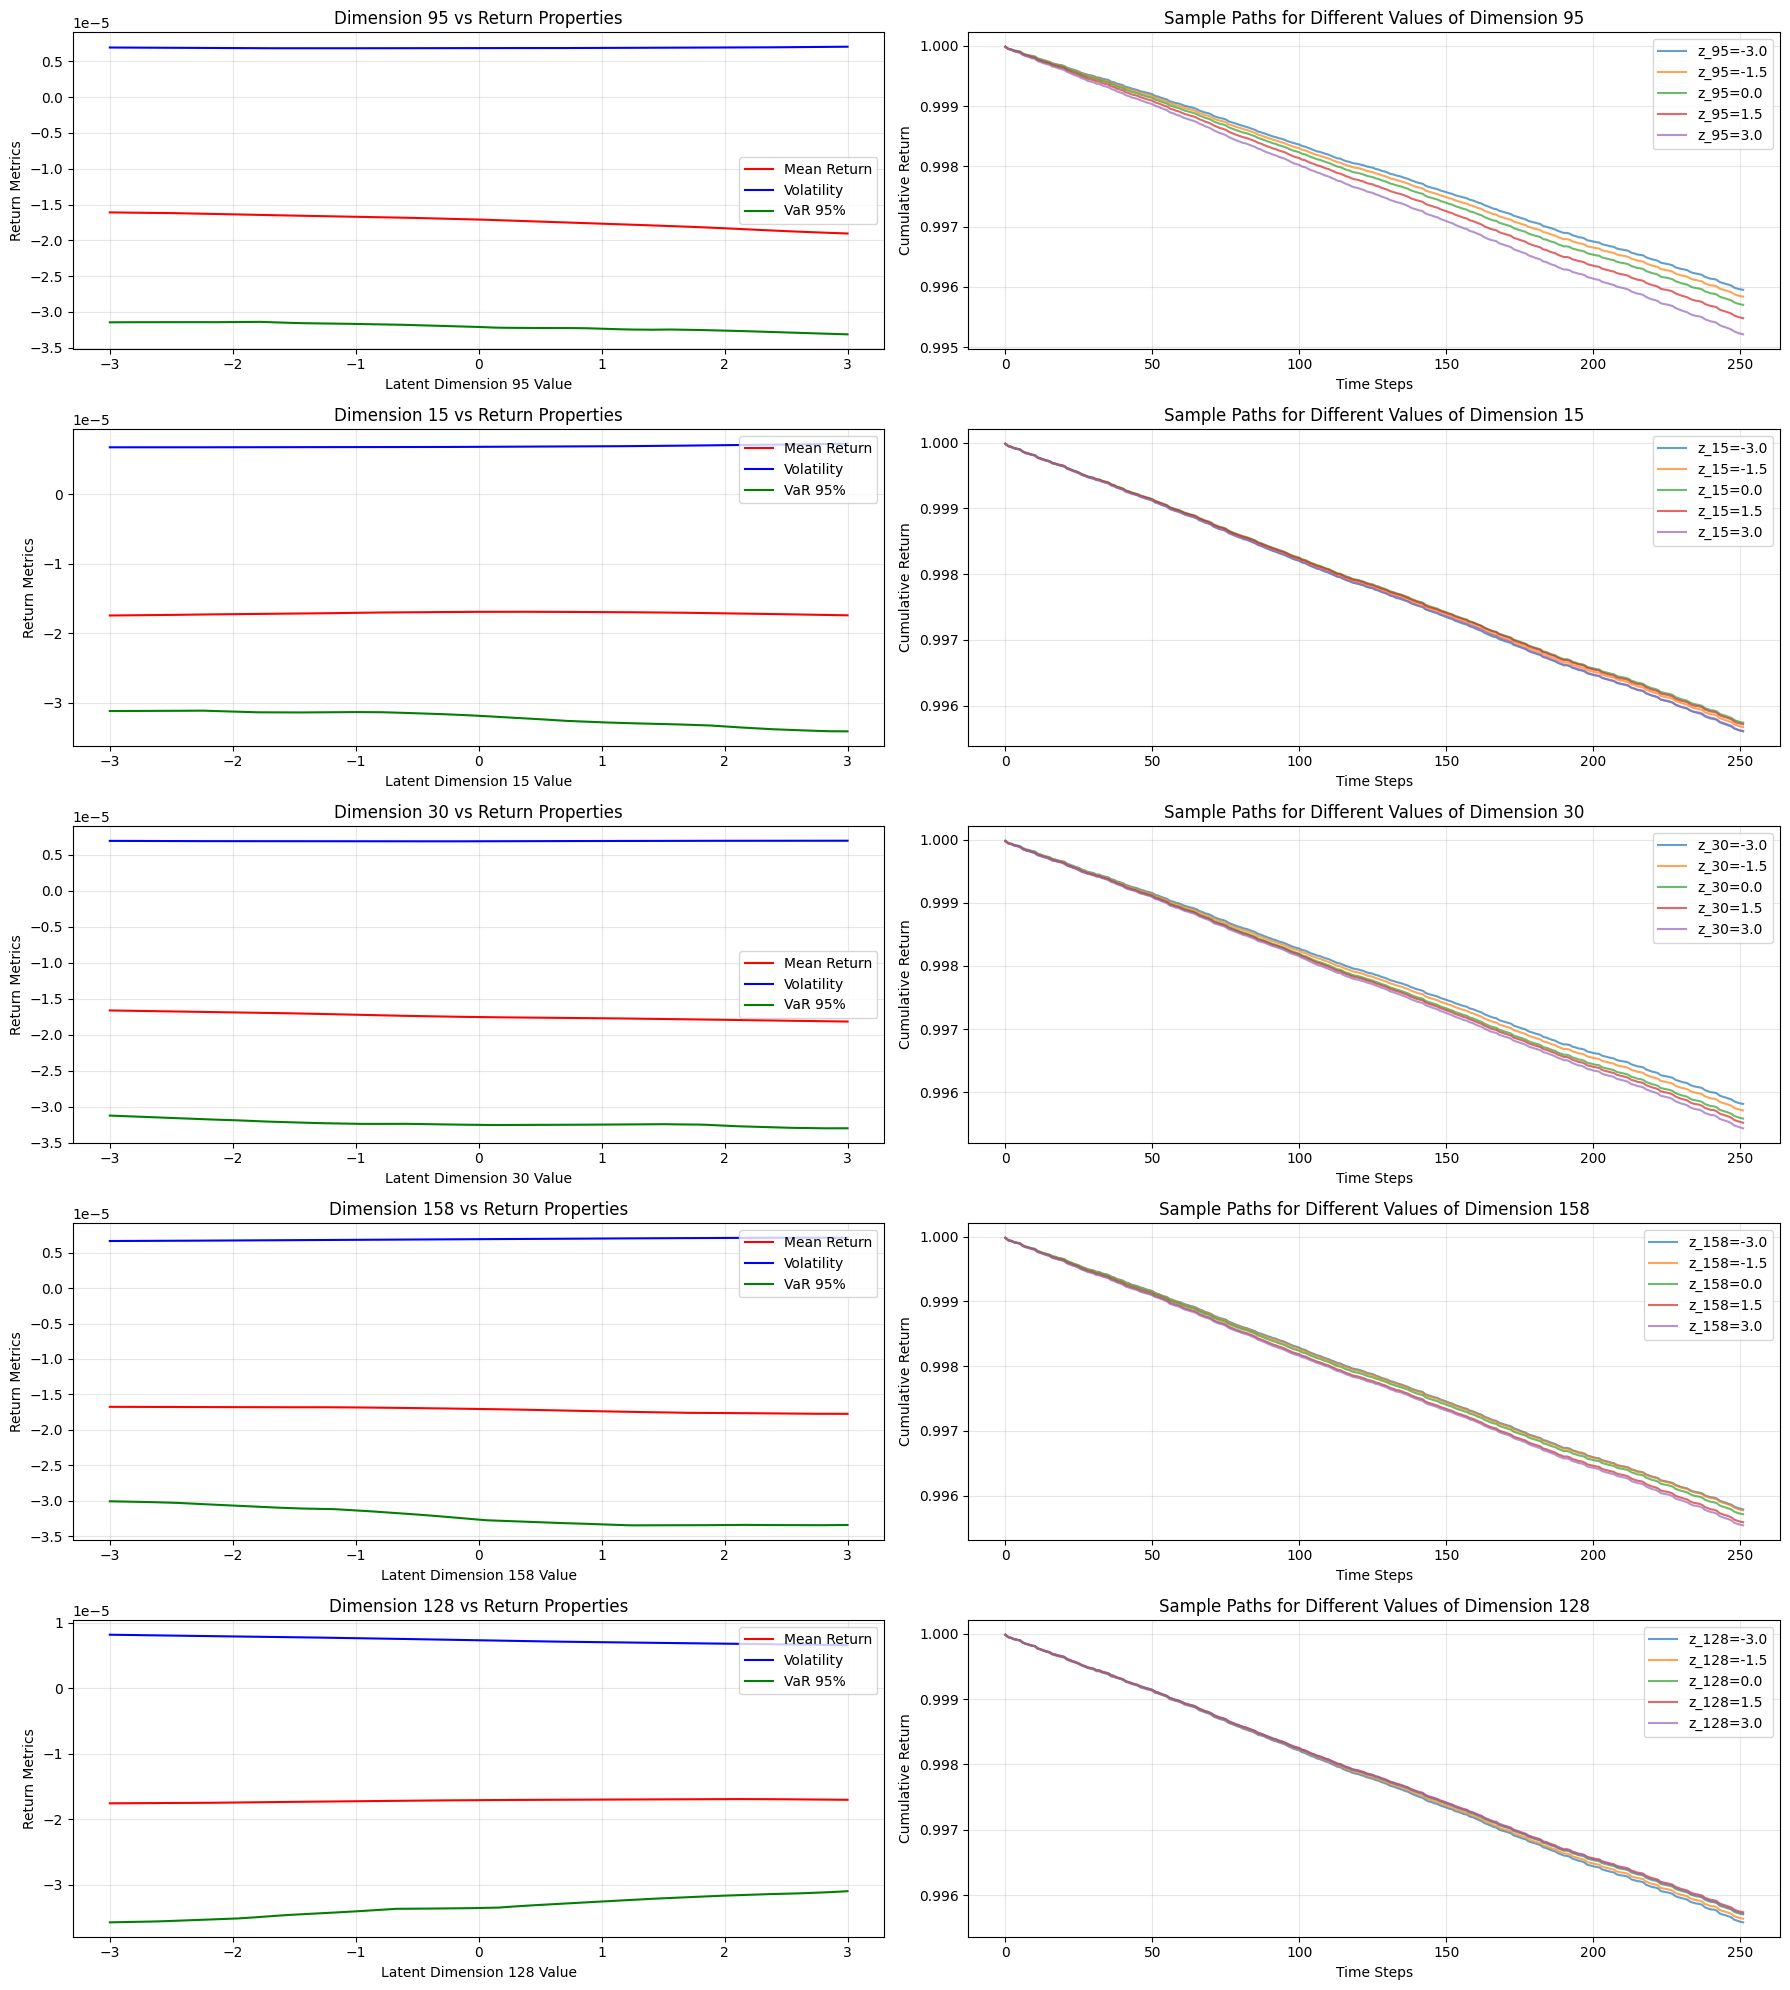

In [ ]:
for asset_name in gan_dict:
    gan = gan_dict[asset_name]
    gen_returns = scenarios_results[asset_name]['scenarios_results']

    explore_latent_space(gan, asset_name)
    #plot_tail_comparison(real_returns, gen_returns)
    

